In [1]:
try:
    %load_ext autoreload
    %autoreload 2
except Exception:
    # Autoreload is optional; continue without it if unavailable
    pass

# Crisp plots in Jupyter without altering global styles
try:
    %config InlineBackend.figure_format = 'retina'
except Exception:
    pass

In [2]:
# =========================
# Standard library imports
# =========================
import logging
logging.disable(logging.WARNING)

import os
import re
import json
import time
import shutil
import hashlib
import platform
import subprocess
from datetime import date
from pathlib import Path  # (deduped)
from typing import Union, Sequence, List, Dict, Any, Optional, Tuple
from collections import defaultdict

# =========================
# Third-party libraries
# =========================
import numpy as np
import numpy.ma as ma
from scipy.stats import lognorm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
import h5py
import yaml

from pyiron_workflow import Workflow
import kanapy as knpy
from kanapy.texture import ODF
from orix.quaternion import Orientation
import damask
# =========================
# Console formatting (ANSI)
# - Use OLD for bold, RESET to clear styles
# - Colors: CYAN / YELLOW / RED
# =========================
OLD   = "\033[1m"
CYAN  = "\033[1;36m"
YELLOW= "\033[1;33m"
RED   = "\033[1;31m"
RESET = "\033[0m"

In [3]:
###############################################################################
# Step 1: Locate path to EBSD map
###############################################################################
@Workflow.wrap.as_function_node("path")
def locate_map_dir(file_extension: str, path: Union[str, Path, None]) -> str:
    """
    Find the first file with the given extension (e.g., '.ang') under `path`. 
    Returns the absolute path as a string.
    """
    print(f"{CYAN}{OLD}########################################################################################{RESET}")
    print(f"{YELLOW}{OLD}Step 1: Locating EBSD file ...........................................................{RESET}")
    print("\n\n")

    # Ensure file_extension starts with a dot (e.g., ".ang")
    ext = file_extension if file_extension.startswith(".") else f".{file_extension}"
    ext = ext.lower()

    # Determine search root (do NOT convert to absolute; we keep things relative)
    search_root  = Path(path) if path is not None else Path.cwd()
    if not search_root.exists() or not search_root.is_dir():
        raise ValueError(f"The provided path '{search_root }' is not a valid directory.")

    found = None
    # Recursive walk; use os.path.join to construct paths
    for dirpath, _, filenames in os.walk(search_root ):
        for fname in filenames:
            if fname.lower().endswith(ext):
                found = os.path.join(dirpath, fname)
                break
        if found is not None:
            break

    if found is None:
        raise FileNotFoundError(f"No file with extension {ext} found in {search_root}")

    # Return relative path to the search root
    rel_path = os.path.relpath(found, start=search_root )

    print(f"{YELLOW}{OLD}Step 1 completed: Located file at {rel_path}{RESET}")
    print(f"{CYAN}{OLD}######################################################################################{RESET}\n")
    print("\n\n")
    return rel_path

In [4]:
###############################################################################
# Step 2: Load and read EBSD map using Kanapy
###############################################################################
@Workflow.wrap.as_function_node("knpyObject")
def load_ebsd_map(file_path: str, show_plot: bool = False) -> "object":
    """
    Load an EBSD map using Kanapy from `file_path`.
    Inputs:
      - file_path (str): Relative or absolute path to the EBSD file (e.g., .ang, .ctf).
      - show_plot (bool): If True, display the EBSD map visualization.
    Outputs:
      - ebsd (kanapy.EBSDmap): The loaded EBSD map object.
    """

    print(f"{CYAN}{OLD}########################################################################################{RESET}")
    print(f"{YELLOW}{OLD}Step 2: Loading EBSD map .............................................................{RESET}")
    print("\n\n")
    
    fp = Path(file_path)
    if not fp.exists():
        raise FileNotFoundError(f"{RED}{OLD}Invalid file path:{RESET} {file_path}. Please ensure the EBSD file exists.")

    ebsd = knpy.EBSDmap(str(fp), show_plot)

    print(f"{YELLOW}{OLD}Step 2 completed: EBSD map loaded from {fp}{RESET}")
    print(f"{CYAN}{OLD}######################################################################################{RESET}\n")
    print("\n\n")
    return ebsd 

In [5]:
###############################################################################
# Step 3: Extract statistical parameters from EBSD map or a JSON file
###############################################################################
@Workflow.wrap.as_function_node("statisticalDescriptors")
def get_stats(source, NVoxels: int = 25, sizeRVE: int = 25, periodic: bool = True) -> Dict[str, Any]:
    """
    Extract microstructure statistics from `source`.
    Inputs:
      - source (str | Path | EBSDmap): JSON file with precomputed stats OR a Kanapy EBSDmap.
      - NVoxels (int): Number of voxels for stats/voxelization grid (default 25).
      - sizeRVE (int): Target RVE size for stats generation (default 25).
      - periodic (bool): Use periodic RVE (default True).
    Outputs:
      - ms_stats (dict): Microstructure stats (grain size, aspect ratio, orientations, etc.).
    """
    print(f"{CYAN}{OLD}########################################################################################{RESET}")
    print(f"{YELLOW}{OLD}Step 3: Extracting microstructure statistics .........................................{RESET}")
    print("\n\n")
    
    # Case 1: If the source is a JSON file, import precomputed statistics
    if isinstance(source, (str, Path)):
        src = str(source)
        if not src.lower().endswith(".json"):
            raise ValueError("Only JSON files can be imported as statistical parameters.")
        if not os.path.isfile(src):
            raise FileNotFoundError(f"The specified JSON file '{src}' does not exist.")
        try:
            ms_stats = knpy.import_stats(src)
        except Exception as error:
            raise ValueError(f"Error reading JSON file '{src}': {error}")

    # Case 2: If the source is Kanapy EBSDmap-like object, compute statistics
    else:
         # Validation for expected attributes
         if not hasattr(source, "ms_data"):
            raise ValueError("Invalid EBSD map object: missing attribute 'ms_data'.")
             
         try:
             # Extract microstructural data from the EBSD map object
             
             ms_data = source.ms_data[0]
             # Normalize phase name: lowercase + underscores
             matname = ms_data["name"].lower().replace(" ", "_")
             
             gs_param = ms_data['gs_param']  # parameters for log-normal distribution of grain size
             ar_param = ms_data['ar_param']  # parameters for log-normal distribution of aspect ratios
             om_param = ms_data['om_param']  # parameters for normal distribution of ellipsoid tilt angles

             # Compute statistics using knpy
             ms_stats = knpy.set_stats(
                 gs_param, 
                 ar_param, 
                 om_param,
                 deq_min=3.0, deq_max=15.0, asp_min=0.95, asp_max=3.5,omega_min=0.0, omega_max=np.pi, 
                 voxels=NVoxels, size=sizeRVE,periodicity=periodic,
                 VF=ms_data["vf"], phasename=matname, phasenum=0
             )

             ms_stats["Data"] = {
                "grain_size": ms_data.get("gs_data"),
                "aspect_ratio": ms_data.get("ar_data"),
            }

         except (KeyError, IndexError, AttributeError) as exc:
             raise ValueError(f"EBSD map object is missing expected fields: {exc}")
             
    print(f"{YELLOW}{OLD}Step 3 completed: Microstructure statistics extracted................................{RESET}")
    print(f"{CYAN}{OLD}#####################################################################################{RESET}\n")
    print("\n\n")
    return ms_stats

In [6]:
###############################################################################
# Step 4: create a RVE for simulating the microstructure of materials
###############################################################################
@Workflow.wrap.as_function_node("RVE")
def generate_rve(source: Dict[str, Any], ori, show_plots: bool = True) -> knpy.Microstructure:
    """
    Build a 3D RVE from microstructure stats in `source` and assign orientations.

    Inputs:
      - source (dict): Microstructure descriptor/stats (e.g., from knpy.set_stats()).
      - ori (str|object|None): 'goss' | 'copper' | 'random' OR a custom orientation object (e.g., ODF).

    Outputs:
      - ms (kanapy.Microstructure): The generated RVE (packed, voxelized, oriented).
    """
    print(f"{CYAN}{OLD}########################################################################################{RESET}")
    print(f"{YELLOW}{OLD}Step 4: Generating RVE ...............................................................{RESET}")
    print("\n\n")
    
    # --- Minimal validation to avoid KeyErrors ---
    if not isinstance(source, dict):
        raise ValueError("`source` must be a dict (e.g., output of knpy.set_stats).")
    phase_dict = source.get("Phase") or {}
    material_name = phase_dict.get("Name")
    
    # 1) Create simulation box with ellipsoidal grains =================================================================
    ms = knpy.Microstructure(descriptor=source, name=f"{material_name}_RVE")
    ms.init_RVE()
    # Creates particle distribution (within the given lower and upper bounds)
    # inside simulation box (RVE) based on the data provided in the data file
    # ==================================================================================================================

    # 2) Perform particle packing ======================================================================================
    ms.pack()
    print("\n\n")
    if show_plots:
        ms.plot_ellipsoids()
    # Simulates grain packing in the box. Particles are initially downscaled
    # to avoid overlap and allow free movement. Collisions are handled during packing.
    # ==================================================================================================================

    # 3) Voxelize to 3D grid ===========================================================================================
    ms.voxelize()
    print("\n\n")
    if show_plots:
        ms.plot_voxels(sliced=True)
    # Converts the packed structure into a voxelated 3D mesh.
    #   Voxels inside grains are assigned to the grain phase, while others
    #   are filled according to a grain growth algorithm.
    # ==================================================================================================================
    print("\n\n")
    if show_plots:    
        ms.plot_stats_init(gs_data=source["Data"]["grain_size"], ar_data=source["Data"]["aspect_ratio"])
    
    # 4 - Assign orientations to grains ================================================================================
    if isinstance(ori, str):
        key = ori.lower().strip()
        if key == "goss":
            ang, omega, texture_desc = [0, 45, 0], 7.5, "unimodel"
        elif key == "copper":
            ang, omega, texture_desc = [90, 35, 45], 7.5, "unimodel"
        elif key == "random":
            ang, omega, texture_desc = None, None, "random"
        else:
            raise ValueError('Unsupported texture string in `ori`. Use "goss", "copper", or "random".')

        ms.generate_orientations(texture_desc, ang=ang, omega=omega, hist=None, Nbase=1000)
    else:
        # Custom orientation object (e.g., EBSD-derived ODF) or None
        ms.generate_orientations(ori) # downsample ODF of EBSD map to actual number of grains
    print("\n\n") 
    if show_plots:
        ms.plot_voxels(ori=True)  # plot voxelized grains in color code of IPF key
    # ==================================================================================================================
    print(f"{YELLOW}{OLD}Step 4 completed: RVE generated.......................................................{RESET}")
    print(f"{CYAN}{OLD}######################################################################################{RESET}\n")
    print("\n\n")
    return ms # Return the generated microstructure object

In [7]:
###################################################################################
# Step 5: write the data json file containing all the data required the simulation
###################################################################################
@Workflow.wrap.as_function_node("dataSchema")
def write_data( source: knpy.Microstructure, fileName: str | Path, user_metadata: dict, boundary_condition: dict, phases: list, units: dict) -> dict:
    """
    Build and save a single JSON data-schema file from a Kanapy Microstructure.
    Inputs:
      - source (kanapy.Microstructure): Voxelized RVE to serialize.
      - fileName (str|Path): Output JSON path (e.g., "_workflow/data_schema.json").
      - user_metadata (dict): Freeform metadata to embed.
      - boundary_condition (dict): BC block to embed.
      - phases (list): Phase descriptors for write_dataSchema.
      - units (dict): Units map, e.g. {"length":"um","stress":"MPa"}.
    Outputs:
      - data (dict): The full data-schema dict that is written to disk.
    """
    print(f"{CYAN}{OLD}########################################################################################{RESET}")
    print(f"{YELLOW}{OLD}Step 5: Exporting data ...............................................................{RESET}")
    print("\n\n")

    # 1) Validate basic inputs ---
    if not isinstance(user_metadata, dict):
        raise ValueError("user_metadata must be a dict")
    if not isinstance(boundary_condition, dict):
        raise ValueError("boundary_condition must be a dict")
    if not isinstance(phases, (list, tuple)):
        raise ValueError("phases must be a list/tuple")
    if not isinstance(units, dict):
        raise ValueError("units must be a dict")
        
    units_norm = {str(k).lower(): v for k, v in units.items()}
    length_unit = units_norm.get("length")
    if length_unit is None:
        length_unit = units.get("Length") or units.get("LENGTH")
    if length_unit is None:
        raise ValueError("units must contain a 'length' entry (e.g., {'length':'um'})")

    # 2) Build schema via Kanapy
    data = source.write_dataSchema(
        user_metadata=user_metadata,
        boundary_condition=boundary_condition,
        phases=phases,
        interactive=False,
        structured=True,
        length_unit=length_unit,
    )
    if not isinstance(data, dict) or not data:
        raise RuntimeError("write_dataSchema did not return a non-empty dict.")
    data["units"] = units # Add units to the data schema

    # 3) Locate grains robustly and validate orientations
    evo = data.get("microstructure_evolution")
    # If evo came back as a list, accept [ {...} ] as well
    if isinstance(evo, list):
        if len(evo) == 1 and isinstance(evo[0], dict):
            evo = evo[0]
        else:
            raise ValueError("Expected 'microstructure_evolution' as dict or single-element list of dict.")
    if not isinstance(evo, dict):
        raise ValueError("Missing or invalid 'microstructure_evolution' block (dict expected).")

    grains = evo.get("grains")
    if not isinstance(grains, list) or len(grains) == 0:
        raise ValueError("Missing or invalid 'grains' list inside 'microstructure_evolution'.")

    # Validate each grain has orientation [Phi1, Phi, Phi2]
    for i, g in enumerate(grains):
        if not isinstance(g, dict):
            raise ValueError(f"Grain at index {i} is not a dict: {type(g).__name__}")
        ori = g.get("orientation")
        if not (isinstance(ori, (list, tuple)) and len(ori) == 3):
            raise ValueError(f"Grain {i} has invalid 'orientation' (need [Phi1, Phi, Phi2]): {ori}")

    Phi1 = [g["orientation"][0] for g in grains]
    Phi  = [g["orientation"][1] for g in grains]
    Phi2 = [g["orientation"][2] for g in grains]
    n_gr = len(grains)

    # 4) Install Euler arrays in the Phase dict (phases[0].orientation.euler_angles) 
    p0 = data["phases"][0]
    p0.setdefault("orientation", {})
    p0["orientation"].setdefault("euler_angles", {})
    p0["orientation"]["euler_angles"]["Phi1"] = Phi1
    p0["orientation"]["euler_angles"]["Phi"]  = Phi
    p0["orientation"]["euler_angles"]["Phi2"] = Phi2
    p0["orientation"]["grain_count"] = n_gr

    # 5) Save JSON
    out_path = str(fileName)
    if not out_path.lower().endswith(".json"):
        out_path += ".json"
    out_path = os.path.join("data", os.path.basename(out_path))
    parent = os.path.dirname(out_path)
    if parent and not os.path.isdir(parent):
        os.makedirs(parent, exist_ok=True)

    with open(out_path, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=2, ensure_ascii=False)
    print("Saved to:", os.path.abspath(out_path))

    print(f"{YELLOW}{OLD}Step 5 completed: data saved in JSON file.............................................{RESET}")
    print(f"{CYAN}{OLD}######################################################################################{RESET}\n")
    print("\n\n")
    return data

In [8]:
###############################################################################
# Step 6: Writing grid, material, and load files to start a DAMASK simulation
###############################################################################
@Workflow.wrap.as_function_node("grid", "material", "load")
def load_to_damask(
    source: dict,
    load: List[List[Union[float, str]]] | List[List[List[Union[float, str]]]],
    grid_out: Union[str, Path] = "grid.vti",
    material_out: Union[str, Path] = "material.yaml",
    load_out: Union[str, Path] = "load.yaml",
    t_list: Sequence[float] = (50.0,),     # total time per step
    N_list: Sequence[int]   = (100,),       # number of increments per step
    f_out_list: Sequence[int] = (1,),       # write results every f_out increments
    f_restart_list: Sequence[int] = (50,),       # write results every f_out increments
    outputs: Sequence[str] = ("F", "P", "F_p", "F_e", "L_p", "O"),
):
    """
    Build DAMASK grid/material/load files from a schema-like `source`.

    Inputs:
      - source (dict): Data schema used by DAMASK helpers (kanapy→DAMASK).
      - load (3x3 or list of 3x3): Deformation-rate matrices per step (numbers or 'x').
      - grid_out/material_out/load_out (str|Path): Output filenames (relative or absolute).
      - t_list, N_list, f_out_list: Per-step times, increments, and output stride.
      - outputs (list[str]): Mechanical outputs to request.

    Outputs:
      - (grid_path, material_path, load_path) as strings (relative to CWD if given that way).
    """
    print(f"{CYAN}{OLD}########################################################################################{RESET}")
    print(f"{YELLOW}{OLD}Step 6: Building grid/material/load from JSON ........................................{RESET}")
    print("\n\n")
    
    grid_out = os.path.join("damaskfiles", grid_out)
    material_out = os.path.join("damaskfiles", material_out)
    load_out = os.path.join("damaskfiles", load_out)
    for fp in (grid_out, material_out, load_out):
        out_dir = os.path.dirname(str(fp))
        if out_dir and not os.path.isdir(out_dir):
            os.makedirs(out_dir, exist_ok=True)
    
    # 1) Basic validation of input JSON ----------------
    if not isinstance(source, dict):
        raise TypeError("`source` must be a dict.")
    if "phases" not in source or not isinstance(source["phases"], list) or len(source["phases"]) == 0:
        raise KeyError("Missing or empty 'phases' array in source.")
    phases_in = source["phases"]

    # 2) Validate step schedules ----------------
    if not (len(t_list) == len(N_list) == len(f_out_list)):
        raise ValueError("t_list, N_list, and f_out_list must have the same length.")
    num_steps = len(t_list)

    for i, (t, N, f) in enumerate(zip(t_list, N_list, f_out_list), start=1):
        if not (isinstance(t, (int, float)) and t > 0):
            raise ValueError(f"Step {i}: t must be > 0 (got {t}).")
        if not (isinstance(N, int) and N >= 1):
            raise ValueError(f"Step {i}: N must be an integer >= 1 (got {N}).")
        if not (isinstance(f, int) and 1 <= f <= N):
            raise ValueError(f"Step {i}: f_out must be an integer in [1, N] (got {f}).")

    # 3) Normalize `load` per your rule ----------------
    # Check if `load` is a single 3x3 matrix
    is_single_3x3 = (
        isinstance(load, list) and
        len(load) == 3 and all(isinstance(row, list) and len(row) == 3 for row in load))
    
    if num_steps == 1:
        # Allow either a 3x3 or a list with one 3x3
        if is_single_3x3:
            loads_per_step = [load]  # wrap single 3x3 as a list of length 1
        else:
            # Is it a list with one 3x3?
            is_list_with_one_3x3 = (
                isinstance(load, list) and
                len(load) == 1 and
                isinstance(load[0], list) and
                len(load[0]) == 3 and
                all(isinstance(r, list) and len(r) == 3 for r in load[0])
            )
            if not is_list_with_one_3x3:
                raise ValueError(
                    "For one step: `load` must be a 3x3 matrix or a list containing one 3x3 matrix."
                )
            loads_per_step = load  # already [3x3]
    else:
        # For multiple steps: require list of length num_steps, each entry a 3x3
        is_list_of_3x3 = (
            isinstance(load, list) and
            len(load) == num_steps and
            all(
                isinstance(m, list) and len(m) == 3 and
                all(isinstance(r, list) and len(r) == 3 for r in m)
                for m in load
            )
        )
        if not is_list_of_3x3:
            raise ValueError(
                f"For {num_steps} steps: `load` must be a list of {num_steps} items, each a 3x3 matrix. "
                "Even if identical, repeat the 3x3 per step."
            )
        loads_per_step = load

    # 4) Geometry ----------------
    grid = damask.GeomGrid.load_kanapy(source)
    grid.save(str(grid_out))
    print(grid)
    print("\n\n")
    # 5) Material (build all phases from `source['phases']`) ----------------
    cfg = damask.ConfigMaterial.load_kanapy(source)
    print(cfg)
    print("\n\n")
    phase_dict: Dict[str, Any] = {}
    

    for p in phases_in:
        pid = p.get("phase_id")
        phase_key = f"{pid}" if pid is not None else None 
        if phase_key is None:
            raise ValueError("Phase entry lacks 'phase_id'.")

        cm = p.get("constitutive_model")
        if not isinstance(cm, dict):
            raise KeyError(f"Phase '{phase_key}' missing 'constitutive_model'.")

        elastic = cm.get("elastic_parameters")
        if not isinstance(elastic, dict):
            raise KeyError(f"Phase '{phase_key}' missing 'elastic_parameters'.")
        for k in ("C11", "C12", "C44"):
            if k not in elastic:
                raise KeyError(f"Phase '{phase_key}' missing elastic parameter '{k}'.")

        # Accept Pa as-is; convert 100..1000 (GPa) → Pa
        C11 = float(elastic["C11"])
        C12 = float(elastic["C12"])
        C44 = float(elastic["C44"])
        
        plastic_params = cm.get("plastic_parameters")
        plasticity_type = cm.get("plastic_model_name")

        if not plasticity_type:
            raise KeyError(f"Phase '{phase_key}' missing 'plastic_model_name'.")
        if not isinstance(plastic_params, dict):
            raise KeyError(f"Phase '{phase_key}' missing 'plastic_parameters' dictionary.")
    
        plastic_block = {"type": plasticity_type}
        plastic_block.update(plastic_params)

        phase_dict[phase_key] = {
            "lattice": "cF",  # FCC for Al; change if your JSON provides lattice info
            "mechanical": {
                "output": list(outputs),
                "elastic": {"type": "Hooke", "C_11": C11, "C_12": C12, "C_44": C44},
                "plastic": plastic_block,
            }
        }

    cfg.update(phase=phase_dict)
    if hasattr(cfg, "is_complete") and not cfg.is_complete:
        raise ValueError("material.yaml is not complete after update (check phases/mechanics).")
    cfg.save(str(material_out))

    # 6) Loadcase (user-defined number of steps) ----------------
    loadsteps = []
    for i in range(num_steps):
        dot_F = loads_per_step[i]
        # P-mask: set 'x' entries to 0;and set numeric entries to 'x'
        P = [[0 if (isinstance(v, str) and v.strip().lower() == 'x') else 'x' for v in row]
     for row in dot_F]

        loadsteps.append({
            "boundary_conditions": {"mechanical": {"dot_F": dot_F, "P": P}},
            "discretization": {"t": float(t_list[i]), "N": int(N_list[i])},
            "f_out": int(f_out_list[i]), "f_restart": int(f_restart_list[i]),
        })

    lc = damask.LoadcaseGrid(
        solver={"mechanical": "spectral_basic"},
        loadstep=loadsteps,
    )
    lc.save(str(load_out))
    grid = str(Path(grid_out).resolve())
    material = str(Path(material_out).resolve())
    loadcase = str(Path(load_out).resolve()) 
    print(f"{YELLOW}{OLD}Step 6 completed: Files are written..................................................{RESET}")
    print(f"{CYAN}{OLD}######################################################################################{RESET}\n")
    print("\n\n") 
    return grid, material, loadcase
        

In [9]:
###############################################################################
# Step 7: Running DAMASK simulations using the FFT grid (spectral) solver
###############################################################################
@Workflow.wrap.as_function_node("results")
def run_damask( grid_file: Union[str, Path], material_file: Union[str, Path], load_file: Union[str, Path] ) -> str:
    """
    Run DAMASK_grid with the provided grid/material/load files.

    Inputs:
      - grid_file (str|Path): Path to grid (.vti).
      - material_file (str|Path): Path to material (.yaml).
      - load_file (str|Path): Path to loadcase (.yaml).

    Outputs:
      - fn_hdf (str): Path to the produced HDF5 results file.
    """
    print(f"{CYAN}{OLD}#########################################################################################{RESET}")
    print(f"{YELLOW}{OLD}Step 7: Start Simulation ..............................................................{RESET}")
    print("\n\n")
    
    # 1) Resolve & validate input paths -------------------------------------------------
    # Use Path for robust path manipulations and clearer file name handling.
    fn_geometry = Path(grid_file)
    fn_material = Path(material_file)
    fn_load     = Path(load_file)

    if not fn_geometry.is_file():
        raise FileNotFoundError(f"Geometry file not found: {fn_geometry}")
    if not fn_material.is_file():
        raise FileNotFoundError(f"Material file not found: {fn_material}")
    if not fn_load.is_file():
        raise FileNotFoundError(f"Load file not found: {fn_load}")

    # Ensure the DAMASK solver is available on PATH.
    if shutil.which("DAMASK_grid") is None:
        raise RuntimeError("DAMASK_grid not found in PATH. Activate your DAMASK env or add it to PATH.")

    damask_dir = fn_geometry.parent
    damask_dir = str(damask_dir)                           
    os.makedirs(damask_dir, exist_ok=True)                 
    log_path = os.path.join(damask_dir, "run.log")

    # 2) Build the command --------------------------------------------------------------
    # Prefer passing a list to Popen over shell=True to avoid shell quirks and quoting issues.
    cmd = [
        "DAMASK_grid",
        "-g", str(fn_geometry),
        "-l", str(fn_load),
        "-m", str(fn_material),
    ]
    print("Running:", " ".join(cmd))

    # 3) Launch process & stream output -------------------------------------------------
    # Merge stderr into stdout so we can stream everything in order and avoid potential deadlocks.
    # text=True gives us str lines; bufsize=1 enables line-buffered streaming.
    with open(log_path, "a", encoding="utf-8") as log:     
        print("Running:", " ".join(cmd), file=log)
        
        process = subprocess.run(
            cmd,
            stdout=log,
            stderr=subprocess.STDOUT,
            text=True,
            check=False,
            cwd=damask_dir,
        )

    # Print solver output live (useful inside notebooks / CI logs).
    #for line in process.stdout:
        #print(line, end="")

    # Wait for completion and get return code.
    #process.wait()

    # 4) Post-process result ------------------------------------------------------------
    if process.returncode != 0:
        print("Error during simulation (non-zero return code).")
        fn_hdf = False  # keep your original sentinel for failure
    else:
        print("Simulation completed successfully.")
        # Many DAMASK runs name the HDF5 as "<geom>_<load>_<mat>.hdf5".
        # Use Path.stem to strip extensions robustly (e.g., ".vti", ".yaml").
        out_name = f"{fn_geometry.stem}_{fn_load.stem}_{fn_material.stem}.hdf5"
        fn_hdf = out_name  # keep as string to match your existing downstream expectations
        fn_hdf = os.path.join(damask_dir, out_name)
        
    print(f"{YELLOW}{OLD}Step 7 completed: Simulation finished ..................................................{RESET}")
    print(f"{CYAN}{OLD}########################################################################################{RESET}\n")
    print("\n\n")
    return fn_hdf

In [10]:
###############################################################################
# Step 8: Post-processing after
###############################################################################
@Workflow.wrap.as_function_node("updatedResults")
def post_processing(results: str, json_path: Union[str, Path], grid_file: Union[str, Path]):
    """
    Post-process a DAMASK HDF5 result and its grid.

    Inputs:
      - results (str|Path): Path to the .hdf5 output from DAMASK.
      - json_path (str|Path): Target JSON filename (bare name or full/relative path).
      - grid_file (str|Path): Path to the .vti grid file.

    Outputs:
       - Path to the updated JSON file.  
    """
    print(f"{CYAN}{OLD}########################################################################################{RESET}")
    print(f"{YELLOW}{OLD}Step 8: Start postprocessing .........................................................{RESET}")
    print("\n\n")

    # 1) Locate result file ----------------
    fn_hdf = str(results)
    if not os.path.exists(fn_hdf):
        raise FileNotFoundError(f"Result file not found: {fn_hdf}")

    # 2) Load results ----------------------
    result = damask.Result(fn_hdf)

    try:
        result.add_stress_Cauchy("P", "F")                         # -> 'sigma'
        result.add_strain("F")                                # -> 'epsilon_V^0.0(F)' (log strain) strain tensor of F
        result.add_equivalent_Mises('sigma')             # -> 'sigma_vM'
        result.add_equivalent_Mises('epsilon_V^0.0(F)')  # -> 'epsilon_vM'
        result.add_IPF_color(l = [1,0,0], q = 'O')       # -> RGB color tuple of inverse pole figure (IPF) color
    except ValueError as e:
        print(f"Skipping variable addition: {e}")

    # Optional quick viewer for the last increment (ignore if not available in headless runs)
    try:
        result.view(increments=-1)
    except Exception as e:
        print(f"Viewer skipped: {e}")

    # 3) Export VTK for ParaView ----------
    damask_dir = os.path.dirname(str(grid_file))
    vtk_dir = os.path.join(damask_dir, "vtk")
    os.makedirs(vtk_dir, exist_ok=True)
    try:
        result.export_VTK(target_dir=vtk_dir)
        print("Exported VTK to:", vtk_dir)
    except Exception as e:
        print(f"VTK export skipped: {e}")

    # 4) Load grid  ------------
    grid = damask.GeomGrid.load(grid_file)

    # Precompute useful arrays
    mat_flat = grid.material.flatten(order='F')
    grain_ids = np.unique(mat_flat)
    n_grains = int(grain_ids.max()) + 1 if grain_ids.size else 0

    # ------------------------------------------------------------------------------
    # 5) Average stress–strain curve
    # ------------------------------------------------------------------------------
    
    cumulative_data = [] 
        
    for inc in result.get(['epsilon_V^0.0(F)', 'P']).values():
        P = inc['P']
        epsilon = inc['epsilon_V^0.0(F)']

        # loop grains, average P11 per grain
        for g in range(n_grains):  
            points = (mat_flat == g)
            if np.sum(points) == 0:  
                continue
                    
            P_11 = P[points, 0, 0].flatten()
            epsilon_11 = np.full_like(P_11, epsilon[:, 0, 0].mean())  
            grain_data = pd.DataFrame({'epsilon_11': epsilon_11, 'P_11': P_11})
            cumulative_data.append(grain_data)  # Append data to list
        
    cumulative_data = pd.concat(cumulative_data, ignore_index=True)  # Convert to DataFrame once
    average_data = cumulative_data.groupby('epsilon_11', as_index=False).mean()

    # --------------------------
    # 5b) Update the JSON file (store curves multiplied by -1)
    # --------------------------
    json_path = Path(os.path.join("data", str(json_path)))
    os.makedirs(os.path.dirname(str(json_path)), exist_ok=True)
    try:
        if json_path.exists():
            data = json.loads(json_path.read_text(encoding='utf-8'))
        else:
            data = {}
    except Exception as e:
        print(f"JSON read failed ({e}); starting from empty object.")
        data = {}
    
    # Multiply by -1 before storing
    neg_strain = (-average_data['epsilon_11'].to_numpy()).astype(float).tolist()
    neg_stress = (-average_data['P_11'].to_numpy()).astype(float).tolist()

    data["strain_11"] = neg_strain
    data["stress_11"] = neg_stress

    json_path.write_text(json.dumps(data, indent=2), encoding='utf-8')
    print(f"Updated JSON with average curve: {json_path}")

    
    # Plot results
    avg_plot = average_data.copy()
    
    avg_plot['epsilon_11'] *= -1.0
    avg_plot['P_11']       *= -1.0
    
    sns.lineplot(x='epsilon_11', y='P_11', data=avg_plot, marker='o')
    plt.xlabel("Average ε11")
    plt.ylabel("Average P11")
    plt.title("Average Stress–Strain Response Across All Grains")
    os.makedirs(os.path.join("figures"), exist_ok=True)
    figure_path_1 = os.path.join("figures", "stress_strain.png")
    plt.savefig(figure_path_1, dpi=300, bbox_inches='tight')
    plt.show()

    # ------------------------------------------------------------------------------
    # 6) Per-grain stress–strain curves for a few grains (0..3)
    #    - x: RVE-average ε_11 per increment
    #    - y: grain-average P_11 per increment
    # ------------------------------------------------------------------------------
    # Run the function
    p0 = data["phases"][0]
    n_gr = p0["orientation"]["grain_count"]
    grains = list(range(n_gr))
    grains_data: Dict[int, pd.DataFrame] = {g: pd.DataFrame() for g in grains}
    
    for inc in result.get(['epsilon_V^0.0(F)','P']).values():
        P = inc['P']
        epsilon = inc['epsilon_V^0.0(F)']
        
        for g in grains:
            points = (mat_flat == g)
            if not np.any(points):
                continue
            P_11 = P[points,0,0].flatten()
            eps11 = np.broadcast_to(np.average(epsilon[:,0,0]), P_11.shape)
            grains_data[g] = pd.concat(
                (grains_data[g], pd.DataFrame({'epsilon_11': eps11, 'P_11': P_11})),
                ignore_index=True)
            
    plot = None
    for g in grains:
        _df = grains_data[g].copy()
        if _df.empty:
            continue
        _df['epsilon_11'] = -_df['epsilon_11']
        _df['P_11']       = -_df['P_11']
        plot = sns.lineplot(y='P_11', x='epsilon_11', data=_df)

    if plot is not None:
        fig = plot.get_figure()
        plt.xlabel("ε11")
        plt.ylabel("P11")
        plt.title("Per-grain Stress–Strain Response")
        figure_path_2 = os.path.join("figures", "stress_strain_per_grain.png")
        plt.savefig(figure_path_2, dpi=300, bbox_inches='tight')
        plt.show()
    else:
        print("No per-grain data to plot.")
        
    print(f"{CYAN}{OLD}##################################################################################################{RESET}")
    print(f"{YELLOW}{OLD}Step 8 completed: End of postprocessing ........................................................{RESET}")
    print("\n\n")
    return json_path


In [11]:
###############################################################################
# Step 9: Updating data schema
###############################################################################
@Workflow.wrap.as_function_node
def update_microstructure_data(
    json_path: Union[str, Path],
    hdf5_path: Union[str, Path],
    n_extract: int = 1,
    *,
    degrees: bool = False,
    time_s: float | Sequence[float] | None = None,   # <-- user-provided time(s)
    out_path: str | Path | None = None,
) -> Path:
    """
    Append n_extract new microstructure_evolution snapshots to a Kanapy-style JSON by
    pulling per-voxel orientations from DAMASK increments.

    - Keeps JSON voxel ordering (C-order list), 1-based voxel_id and voxel_index as-is.
    - Uses 1-based voxel_index [i,j,k] to compute the Fortran-order linear index for DAMASK
      flat arrays, then updates each voxel's `orientation` (Euler Bunge), centroid, and volume.
    - Then updates grain-level `grain_volume` (sum of voxel volumes) and `orientation`   
      (unweighted circular mean of voxel Euler angles per grain).                        
    - Increments chosen as:
        n_extract == 1 → only the last increment
        n_extract  > 1 → evenly spaced interior increments (excluding 0) plus the last
    - No time is read from DAMASK. If you pass `time_s`:
        * float → applied to all appended snapshots
        * sequence[float] → must match number of appended snapshots
        * None → no `time` field is written
    """
    print(f"{CYAN}{OLD}########################################################################################{RESET}")
    print(f"{YELLOW}{OLD}Step 9: updating json data file ......................................................{RESET}")
    print("\n\n")
    json_path = Path(json_path)
    hdf5_path = Path(hdf5_path)
    if out_path is None:
        out_path = json_path.with_name(json_path.stem + "__updated.json")
    out_path = Path(out_path)

    # -------- JSON load & checks --------
    data = json.loads(json_path.read_text())
    if "microstructure_evolution" not in data or not data["microstructure_evolution"]:
        raise ValueError("JSON missing 'microstructure_evolution[0]'.")
    evo0 = data["microstructure_evolution"][0]
    voxels = evo0.get("voxels")
    if not isinstance(voxels, list) or not voxels:
        raise ValueError("JSON missing 'microstructure_evolution[0].voxels' list.")

    # -------- Grid sizes from size/spacing --------
    size    = np.asarray(data["RVE_size"], float)
    spacing = np.asarray(data["discretization_unit_size"], float)
    cells_f = size / spacing
    cells   = np.rint(cells_f).astype(int)
    if not np.allclose(cells_f, cells, atol=0, rtol=0):
        raise ValueError(f"Non-integer voxel counts from size/spacing: {cells_f}")
    Nx, Ny, Nz = map(int, cells.tolist())
    N_calc = int(Nx * Ny * Nz)
    N_json = int(data.get("discretization_count", N_calc))
    if N_calc != N_json:
        raise ValueError(f"discretization_count mismatch: JSON={N_json} vs computed={N_calc}")
    if len(voxels) != N_calc:
        raise ValueError(f"voxels list length ({len(voxels)}) != Nx*Ny*Nz ({N_calc})")

    # -------- Open DAMASK & pick increments --------
    result = damask.Result(str(hdf5_path))
    if not result.increments:
        raise ValueError("No increments found in DAMASK result.")
    inc_ids: List[str] = result.increments
    last_idx = len(inc_ids) - 1

    if n_extract == 1:
        pick_idxs = [last_idx]  # only last increment
    else:
        interior_count = n_extract - 1
        if last_idx - 1 >= 1 and interior_count > 0:
            interior = np.linspace(1, last_idx - 1, num=interior_count, dtype=int).tolist()
        else:
            interior = []
        pick_idxs = sorted(set(interior + [last_idx]))

    selected = [inc_ids[i] for i in pick_idxs]
    print("selected:", selected)

    # Normalize time_s input to a list aligned with `selected`
    time_values: List[float] | None
    if time_s is None:
        time_values = None
    elif isinstance(time_s, (int, float)):
        time_values = [float(time_s)] * len(selected)
    else:
        time_values = list(map(float, time_s))
        if len(time_values) != len(selected):
            raise ValueError(
                f"'time_s' has length {len(time_values)} but {len(selected)} increments are selected."
            )
        
    # -------- Extract and append snapshots --------
    for idx, inc_id in enumerate(selected):
        result.view(increments=[inc_id])

        # orientations (quaternions → Euler Bunge)
        tree_O = result.get(['O'], flatten=False, prune=False)
        try:
            O_q = tree_O[inc_id]['phase']['0']['mechanical']['O']  # (N,4)
        except KeyError as e:
            raise KeyError(f"Could not locate 'O' at {inc_id} in DAMASK tree.") from e
        if O_q.shape != (N_calc, 4):
            raise ValueError(f"Unexpected 'O' shape at {inc_id}: {O_q.shape} vs {(N_calc,4)}")

        eu = damask.Rotation.from_quaternion(O_q).as_Euler_angles(degrees=degrees)

        # Expect exactly: increment → geometry → u_p  with shape (N,3)
        tree_geom_up = result.get(['geometry', 'u_p'], flatten=False, prune=False)
        try:
            U = np.asarray(tree_geom_up[inc_id]['geometry']['u_p'], float)
        except Exception as e:
            raise KeyError(f"Displacements not found at {inc_id} under 'geometry/u_p'.") from e
        if U.shape != (N_calc, 3):
            raise ValueError(f"Unexpected displacement shape at {inc_id}: {U.shape} (expected {(N_calc,3)})")
                       
        # Deformation gradient and Jacobian J = det(F)
        F = None
        try:
            tree_F = result.get(['phase', '0', 'mechanical', 'F'], flatten=False, prune=False)
            F = np.asarray(tree_F[inc_id]['phase']['0']['mechanical']['F'], float)
            if F.shape != (N_calc, 3, 3):
                F = None
        except Exception:
            F = None
        if F is None:
            tree_F2 = result.get(['F'], flatten=False, prune=False)
            node2 = tree_F2.get(inc_id)
            if isinstance(node2, dict) and 'F' in node2:
                F = np.asarray(node2['F'], float)
            else:
                F = np.asarray(node2, float)
            if F.shape != (N_calc, 3, 3):
                raise ValueError(f"Unexpected F shape at {inc_id}: {F.shape} (expected {(N_calc,3,3)})")

        J = np.linalg.det(F)                  # (N,)
        
        # build snapshot (no time extraction here)
        snap = deepcopy(evo0)
        if time_values is not None:
            snap["time"] = float(time_values[idx])
            
        # ---- update voxel-level fields respecting original JSON order ----
        
        
        # update orientations respecting original JSON voxel order and 1-based indices
        for v in snap["voxels"]:
            i, j, k = v["voxel_index"]  # 1-based 
            # L = (i-1) + Nx * ((j-1) + Ny * (k-1))
            L = (i - 1) + Nx * ((j - 1) + Ny * (k - 1)) # Fortran (x-fastest) linear index from 1-based [i,j,k]

            # Orientation
            v["orientation"] = eu[L].tolist()

            # Centroid += displacement
            c0 = np.asarray(v.get("centroid_coordinates", [0.0, 0.0, 0.0]), float)
            v["centroid_coordinates"] = (c0 + U[L]).tolist()

            # Deformed volume = J * V0
            V0 = float(v.get("voxel_volume", 0.0))
            J_L = float(J[L])
            if J_L < 0 and J_L > -1e-10:  # tiny negative due to round-off
                J_L = 0.0
            v["voxel_volume"] = V0 * J_L
            
        # ===================== GRAINS: aggregation from updated voxels =====================
        
        ang_sin = defaultdict(lambda: np.zeros(3, float))  
        ang_cos = defaultdict(lambda: np.zeros(3, float))  
        counts  = defaultdict(int)                         
        vol_sum = defaultdict(float)  
        
        # Collect per-grain stats (unweighted circular mean of Euler + volume sum)
        for v in snap["voxels"]:                                                
            gid = int(v.get("grain_id", -1))                                    
            if gid == -1:                                                      
                continue                                                       
            eul = np.asarray(v["orientation"], float)                      
            if degrees:                                                     
                eul = np.deg2rad(eul)                                       
            ang_sin[gid] += np.sin(eul)                                         
            ang_cos[gid] += np.cos(eul)                                   
            counts[gid]  += 1                                                  
            vol_sum[gid] += float(v.get("voxel_volume", 0.0))
            
        grains_list = snap.get("grains", [])
        by_id = {int(g["grain_id"]): g for g in grains_list if "grain_id" in g}
        
        # Update existing grains                                                 
        for gid, g in by_id.items():                                            
            if counts.get(gid, 0) > 0:                                          
                m = np.arctan2(ang_sin[gid], ang_cos[gid])  # radians     
                m[0] = m[0] % (2*np.pi)
                m[2] = m[2] % (2*np.pi)
                if degrees:                                                     
                    m = np.rad2deg(m)                                           
                g["orientation"] = m.tolist()                                   
                g["grain_volume"] = float(vol_sum[gid])
        
        # Create missing grains if referenced by voxels                        
        for gid in counts.keys():                                             
            if gid not in by_id:                                                
                m = np.arctan2(ang_sin[gid], ang_cos[gid])  # radians 
                m[0] = m[0] % (2*np.pi)
                m[2] = m[2] % (2*np.pi)
                if degrees:                                                    
                    m = np.rad2deg(m)                                           
                grains_list.append({                                            
                    "grain_id": int(gid),                                     
                    "phase_id": 0,                                              
                    "grain_volume": float(vol_sum[gid]),                      
                    "orientation": m.tolist(),                                  
                })
        snap["grains"] = grains_list
        # =================== END GRAINS ================================================
        
        data["microstructure_evolution"].append(snap)

    out_path.write_text(json.dumps(data, indent=2))
    print(f"{YELLOW}{OLD}Step 9 completed: End of updating ..............................................................{RESET}")
    print(f"{CYAN}{OLD}##################################################################################################{RESET}")
    print("\n\n")
    return out_path

In [12]:
###############################################################################
# Step 10: Remeshing of the grid
###############################################################################
@Workflow.wrap.as_function_node("mapping", "regrid")
def mesh_replacement(hdf5_path: Union[str, Path],
                     grid: Union[str, Path],
                     source_path: Union[str, Path]):
    """
    Remesh the DAMASK grid using the last-increment deformation and write restart files.

    - Computes F_avg from the final increment, derives new voxel counts, and builds a regrid mapping.
    - Assembles and saves a new grid ('grid-2.vti') and remapped results ('grid-2_load_material.hdf5').
    - Creates a restart file remapped to the new grid ('grid-2_load_material_restart.hdf5').
    - Exports VTK output to source_path/'vtk_restart'.

    Returns
    -------
    mapping : np.ndarray
        Index mapping from old to new grid (Fortran layout).
    """
    print(f"{CYAN}{OLD}########################################################################################{RESET}")
    print(f"{YELLOW}{OLD}Step 10: start remeshing .............................................................{RESET}")
    print("\n\n")
    
    F = []
    P = []
    base_h5   = Path(hdf5_path)
    Results = damask.Result(base_h5)
    F.append([np.average(_,axis=0) for _ in Results.place('F').values()])
    P.append([np.average(_,axis=0) for _ in Results.place('P').values()])
    
    F_last_field = Results.view(increments=-1).place('F')          # (N,3,3) possibly MaskedArray
    F_last_field = ma.getdata(F_last_field)                        # -> plain ndarray
    F_avg = np.average(F_last_field, axis=0)                       # (3,3)
    
    nx, ny, nz = Results.cells # Counts of voxels in each direction
    cells_old = np.array([nx, ny, nz], dtype=int)

    # Length of the RVE in each direction
    size_xyz = ma.getdata(Results.size).astype(float)              # (3,) ndarray
    
    # New cells (new counts for each direction)
    cells = np.asarray(cells_old, float).reshape(3)
    # map cells by average F, guard against sign/zero
    proposed = F_avg @ cells
    proposed = np.maximum(np.abs(proposed), 1e-9)
    # keep largest resolution roughly constant
    scale = float(np.max(cells / proposed))
    out = np.rint(proposed * scale).astype(int)
    min_cells=1
    cells_new = np.maximum(out, min_cells)
    
    # reshape to (nx,ny,nz,3,3) **Fortran order**
    F_field_xyz = F_last_field.reshape((nx, ny, nz, 3, 3), order='F')
    
    # --- ensure everything passed to regrid is plain ndarray ---
    F_field_xyz = np.asarray(F_field_xyz, dtype=float)
    size_xyz    = np.asarray(size_xyz, dtype=float)
    cells_new   = np.asarray(cells_new, dtype=int)
    
    # compute mapping
    mapping_phase = Results._mappings()[0][0]
    mapping = damask.grid_filters.regrid(size_xyz, F_field_xyz, cells_new)
    mapping_flat = mapping.reshape(-1,order='F')
    
    g = damask.GeomGrid.load(grid)
    g.size = F_avg@g.size
    g2 = g.assemble(mapping)

    damask_dir = os.path.dirname(str(grid))
    grid2 = Path(os.path.join(damask_dir, 'grid-2.vti'))
    g2.save(grid2)

    hdf5_2 = 'grid-2_load_material.hdf5'
    hdf5_2_path = Path(os.path.join(damask_dir, hdf5_2))
    #hdf5_restart = 'grid_load_material_restart.hdf5'
    hdf5_restart_path   = base_h5.with_name(base_h5.stem + "_restart.hdf5") 
    #hdf5_restart_2 = 'grid-2_load_material_restart.hdf5'
    hdf5_restart_2_path = Path(os.path.join(damask_dir, 'grid-2_load_material_restart.hdf5'))

    if hdf5_restart_path.exists():
        with (h5py.File(hdf5_restart_path) as f_in, h5py.File(hdf5_restart_2_path,'w') as f_out):
            f_in.copy('homogenization',f_out)
            f_out.create_group('phase')
            for label in f_in['phase']:
                m = mapping_flat[np.isin(mapping_flat,mapping_phase[label])]
                for i,j in enumerate(mapping_phase[label]):
                    m[m==j] = i
                f_out['phase'].create_group(label)
                F_e0 = np.matmul(f_in['phase'][label]['F'][()],np.linalg.inv(f_in['phase'][label]['F_p'][()]))
                R_e0, V_e0 = damask.mechanics._polar_decomposition(F_e0, ['R','V'])
                f_out['phase'][label].create_dataset('F',data=np.broadcast_to(np.eye(3),(len(m),3,3,)))
                f_out['phase'][label].create_dataset('F_e',data=R_e0[m])
                f_out['phase'][label].create_dataset('F_p',data=damask.tensor.transpose(R_e0)[m])
                f_out['phase'][label].create_dataset('S',data=np.zeros((len(m),3,3)))
                for d in f_in['phase'][label]:
                    if d in f_out[f'phase/{label}']: continue
                    f_out['phase'][label].create_dataset(d,data=f_in['phase'][label][d][()][m])
    
            f_out.create_group('solver')
            for d in ['F','F_lastInc']:
                f_out['solver'].create_dataset(d,data=np.broadcast_to(np.eye(3),np.append(cells_new.prod(),(3,3))))
            for d in ['F_aim', 'F_aim_lastInc']:
                f_out['solver'].create_dataset(d,data=np.eye(3))
            f_out['solver'].create_dataset('F_aimDot',data=np.zeros((3,3)))
            for d in f_in['solver']:
                if d not in f_out['solver']: f_in['solver'].copy(d,f_out['solver'])
    else:
        print(f"Restart file not found, skipping restart remap: {hdf5_restart_path}")
        
    Results.view(increments=0).export_DADF5(hdf5_2_path,mapping=mapping)
    
    with h5py.File(hdf5_2_path,'a') as f:
        f['geometry'].attrs['size'] = g.size
        
    Results2 = damask.Result(hdf5_2_path)
    vtk_dir = os.path.join(damask_dir, "vtk_restart")
    os.makedirs(vtk_dir, exist_ok=True)
    Results2.export_VTK(target_dir=vtk_dir)
    print(f"{YELLOW}{OLD}Step 10 completed: End of remeshing ............................................................{RESET}")
    print(f"{CYAN}{OLD}##################################################################################################{RESET}")
    print("\n\n")
    return mapping, grid2

In [13]:
###############################################################################
# Step 11: Remap to data file
###############################################################################
@Workflow.wrap.as_function_node
def remap_to_data_file(json_updated: Union[str, Path],
    mapping: Union[np.ndarray, Sequence[int]],
    grid_file: Union[str, Path],
    time_value: Optional[float] = None,
    update_top_level: bool = True):
    """
    Remap last-increment microstructure fields to a new regular (isotropic) grid
    and append a regridded snapshot to the same data file.

    Steps:
      1) Load JSON and extract the *last* snapshot (voxels: grain_id, orientation, centroid, volume).
      2) Load target grid (VTI) and compute isotropic spacing dx_iso by snapping the x-spacing to 1e-3.
      3) Apply DAMASK `mapping` (new-index → old-Fortran-index) to remap grain/euler/volume.
      4) Rebuild voxels on the new grid using *regular* centroids at (i-0.5)*dx_iso + origin.
      5) Recompute per-grain table (volume + circular mean of Euler angles in radians).
      6) Append the new snapshot and, if requested, update top-level discretization/size metadata.
      7) Write to `data/<base>_1.json` and print min/max voxel checks.

    Returns:
      str: Path to the written JSON file.
    """
    print(f"{CYAN}{OLD}#####################################################################################################{RESET}")
    print(f"{YELLOW}{OLD}Step 11: start remapping to data file .............................................................{RESET}")
    print("\n\n")
    # 1) Remap last-increment fields to new grid
    data = json.loads(Path(json_updated).read_text())
    
    # old deformed, last increment
    if "microstructure_evolution" not in data or not data["microstructure_evolution"]:
        raise ValueError("No 'microstructure_evolution' snapshots found in JSON.")
    evo = data["microstructure_evolution"][-1]
    vox = evo.get("voxels", [])
    if not vox:
        raise ValueError("Last snapshot has no 'voxels' entries.")

     # -- Extract original grid dims from top-level (size / spacing), ensure integer counts
    size    = np.asarray(data["RVE_size"], float)
    spacing = np.asarray(data["discretization_unit_size"], float)
    cells_f = size/spacing
    cells   = np.rint(cells_f).astype(int)
    if not np.allclose(cells_f, cells, atol=0, rtol=0):
        raise ValueError(f"Non-integer voxel counts from size/spacing: {cells_f}")
    Nx,Ny,Nz = tuple(map(int, cells.tolist()))  # (Nx,Ny,Nz)
    print("old size of voxel in each direction:", spacing)
    print("old size of RVE in each direction:", size)
    print("old number of voxels in each direction:", cells)
    
    N = Nx*Ny*Nz
    grain_F   = np.empty(N, dtype=np.int32)
    euler_F   = np.empty((N,3), dtype=float)
    centro_F  = np.empty((N,3), dtype=float)
    vol_F     = np.empty(N, dtype=float)
    
    for v in vox:
        i,j,k = map(int, v["voxel_index"])   # 1-based
        L = (i-1) + Nx*((j-1) + Ny*(k-1))       # Fortran linear
        grain_F[L]  = int(v["grain_id"])
        euler_F[L]  = np.asarray(v["orientation"], float)
        centro_F[L] = np.asarray(v["centroid_coordinates"], float)
        vol_F[L]    = float(v.get("voxel_volume", 0.0))
    
    # -- Load new grid and prepare mapping
    g2 = damask.GeomGrid.load(grid_file)
    Nx2,Ny2,Nz2 = map(int, g2.cells)
    mapping_flat = mapping.reshape(-1, order='F')   # new idx → old L_F
    if mapping_flat.size != (Nx2 * Ny2 * Nz2):
        raise ValueError(
            f"Mapping size {mapping_flat.size} does not match target grid cells {Nx2*Ny2*Nz2}."
        )
        
    grain_new_F  = grain_F[mapping_flat]
    euler_new_F  = euler_F[mapping_flat]
    #centro_new_F = centro_F[mapping_flat] #(centroids are re-generated below on the *regular* new grid)
    
    # UPDATED: isotropic spacing from g2 → use dx only (snapped)
    size2  = np.asarray(g2.size,  float)
    cells2 = np.asarray(g2.cells, float)
    sp2    = size2 / cells2                      # [dx, dy, dz]
    dx_iso = float(np.round(float(sp2[0]) / 1e-3) * 1e-3)
    vol_new_F = np.full(mapping_flat.size, float(dx_iso**3), dtype=float)
    
    # reshape to (Nx2,Ny2,Nz2) Fortran layout when needed
    grain_new_3d = grain_new_F.reshape((Nx2,Ny2,Nz2), order='F')
    
    # 3) Append a regridded snapshot into JSON (keeps deformed centroids/orientations)
    # -- Build voxels on the regular new grid (Fortran order)
    size2   = np.asarray(g2.size,   float)
    origin2 = np.asarray(g2.origin, float)
    dx2  = np.array([dx_iso, dx_iso, dx_iso], float)
    # We’ll **use mapped centroids & orientations** from last increment:
    # centroids already deformed; euler from last increment.
    # (If you prefer geometric centers, replace centro_new_F below.)
    voxels_new = []
    vid = 1
    for k in range(1, Nz2+1):
        for j in range(1, Ny2+1):
            for i in range(1, Nx2+1):
                L = (i-1) + Nx2*((j-1) + Ny2*(k-1))
                # UPDATED: regular undeformed centroids
                cx = origin2[0] + (i - 0.5) * dx2[0]
                cy = origin2[1] + (j - 0.5) * dx2[1]
                cz = origin2[2] + (k - 0.5) * dx2[2]
                voxels_new.append({
                    "voxel_id": vid,
                    "grain_id": int(grain_new_F[L]),
                    "centroid_coordinates": [float(cx), float(cy), float(cz)],  # UPDATED
                    "voxel_index": [i,j,k],
                    "voxel_volume": float(vol_new_F[L]),  # = dx_iso**3
                    "orientation": [float(x) for x in euler_new_F[L]], # radians
                })
                vid += 1

    # Grain table: volume + circular mean of Euler (radians)
    vol_sum = defaultdict(float)
    ang_sin = defaultdict(lambda: np.zeros(3, float))
    ang_cos = defaultdict(lambda: np.zeros(3, float))
    cnt     = defaultdict(int)
    for v in voxels_new:
        gid = int(v["grain_id"])
        vol_sum[gid] += v["voxel_volume"]
        e = np.asarray(v["orientation"], float)  # radians (your JSON is radians)
        ang_sin[gid] += np.sin(e)
        ang_cos[gid] += np.cos(e)
        cnt[gid] += 1

    grains_new = []
    for gid in sorted(vol_sum.keys()):
        if cnt[gid] > 0:
            m = np.arctan2(ang_sin[gid], ang_cos[gid])
            m[0] = m[0] % (2*np.pi)
            m[2] = m[2] % (2*np.pi)
            grains_new.append({
                "grain_id": int(gid),
                "phase_id": 0,
                "grain_volume": float(vol_sum[gid]),
                "orientation": [float(x) for x in m],
            })

    snap = {
        "time": (float(time_value) if time_value is not None else 0.0),
        "grains": grains_new,
        "voxels": voxels_new,
    }
    data["microstructure_evolution"].append(snap)
    if update_top_level:
        # UPDATED: isotropic metadata
        data["discretization_unit_size"] = [dx_iso, dx_iso, dx_iso]
        data["discretization_count"] = int(Nx2*Ny2*Nz2)
        iso_size = dx_iso * np.array([Nx2, Ny2, Nz2], float)
        data["RVE_size"] = [float(x) for x in iso_size]
    
    print("New size of voxel in each direction:", data["discretization_unit_size"])
    print("New size of RVE in each direction:", data["RVE_size"])
    print("New number of voxels:", data["discretization_count"])  # fixed

    # -- Write out
    base = Path(json_updated).stem
    out_path = os.path.join("data", f"{base}_1.json")
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    Path(out_path).write_text(json.dumps(data, indent=2))
    print("Updated JSON file is written:", out_path)
    # -- Quick check: min/max centroid by sum (unchanged logic)
    with open(out_path) as f:
        data_chk = json.load(f)
    snap_chk = data_chk["microstructure_evolution"][-1]
    vox_chk = snap_chk["voxels"]
    C = np.array([v["centroid_coordinates"] for v in vox_chk])
    imin = C.sum(axis=1).argmin()
    imax = C.sum(axis=1).argmax()
    v_min = vox_chk[imin]
    v_max = vox_chk[imax]
    print("Lowest-coordinate voxel:\n index:", v_min["voxel_index"], "\n coord:", v_min["centroid_coordinates"])
    print("\nHighest-coordinate voxel:\n index:", v_max["voxel_index"], "\n coord:", v_max["centroid_coordinates"])
    print(f"{YELLOW}{OLD}Step 11 completed: End of remapping ............................................................{RESET}")
    print(f"{CYAN}{OLD}##################################################################################################{RESET}")
    print("\n\n")
    return out_path

In [14]:
###############################################################################
# Step 12: Create mesh object and analyse using kanapy
###############################################################################
@Workflow.wrap.as_function_node("initial", "regridded")
def extract_stats(json_updated: Union[str, Path], ms:knpy.Microstructure, show_plot: bool = True):
    """
    Build a minimal mesh adapter from a regridded JSON snapshot and call
    `knpy.core.rve_stats.get_stats_vox` to extract microstructure statistics.

    Process:
      1) Load the 3rd snapshot (index 2) from `json_updated`.
      2) Reconstruct a regular node grid from voxel centroids (origin = min(C) - dx/2).
      3) Map each voxel to its 8 corner node IDs (1-based), matching ij-indexing and
         C-order ravel with k fastest.
      4) Assemble grain–voxel mapping and grain→phase table (default phase 0).
      5) Wrap in a MeshAdapter and call `get_stats_vox`.
      6) Return both stats: {"initial": ..., "regridded": ...}.
    Returns:
      dict with keys:
        - "initial":   stats dict from `ms.mesh` if provided, else None          
        - "regridded": stats dict from the rebuilt mesh (snapshot index 2)
    """
    print(f"{CYAN}{OLD}#####################################################################################################{RESET}")
    print(f"{YELLOW}{OLD}Step 12: Extract statistics from regridded RVE ....................................................{RESET}")
    print("\n\n")

    # --- (A) Optional: initial stats from precomputed Microstructure mesh ----------------------------  
    initial_state = None 
    print("The initial microstructure")
    print("\n\n")
    if ms is not None and hasattr(ms, "mesh") and ms.mesh is not None:                           
        initial_state = knpy.core.rve_stats.get_stats_vox(ms.mesh, show_plot=show_plot)
        
    # --- 1) Load 3rd snapshot (regridded) ---
    with open(json_updated) as f:
        data = json.load(f)
        
    # ensure we actually have a third snapshot                                      
    if "microstructure_evolution" not in data or len(data["microstructure_evolution"]) <= 2:  
        raise ValueError("Expected at least 3 snapshots (need index 2) in 'microstructure_evolution'.")  
        
    snap = data["microstructure_evolution"][2]
    vox  = snap["voxels"]
    gr_table = {g["grain_id"]: g for g in snap.get("grains", [])}
    
    # --- 2) Grid sizes & spacing (isotropic) ---
    size   = np.asarray(data["RVE_size"], float)
    dunit  = np.asarray(data["discretization_unit_size"], float)
    Nx, Ny, Nz = (size / dunit + 1e-9).astype(int)
    dx = float(dunit[0])
    
    # origin from centroids: origin = min(C) - dx/2
    C = np.array([v["centroid_coordinates"] for v in vox], float)
    origin = C.min(axis=0) - 0.5 * dx
    
    # --- 3) Nodes: origin + [i*dx, j*dx, k*dx]
    ii, jj, kk = np.meshgrid(
        np.arange(Nx + 1), np.arange(Ny + 1), np.arange(Nz + 1), indexing="ij"
    )
    nodes = np.column_stack((
        origin[0] + ii.ravel() * dx,
        origin[1] + jj.ravel() * dx,
        origin[2] + kk.ravel() * dx,
    )).astype(float)

    # --- 4) Voxel connectivity + grain maps
    voxel_dict = {}
    grain_dict = {}
    grain_phase_dict = {}
    
    for v in vox:
        vid = int(v["voxel_id"])
        i, j, k = (int(v["voxel_index"][0])-1,
                   int(v["voxel_index"][1])-1,
                   int(v["voxel_index"][2])-1)  # to 0-based
    
        n000 = 1 + i*(Ny+1)*(Nz+1) + j*(Nz+1) + k         
        n100 = 1 + (i+1)*(Ny+1)*(Nz+1) + j*(Nz+1) + k    
        n010 = 1 + i*(Ny+1)*(Nz+1) + (j+1)*(Nz+1) + k   
        n110 = 1 + (i+1)*(Ny+1)*(Nz+1) + (j+1)*(Nz+1) + k 
        n001 = 1 + i*(Ny+1)*(Nz+1) + j*(Nz+1) + (k+1)     
        n101 = 1 + (i+1)*(Ny+1)*(Nz+1) + j*(Nz+1) + (k+1) 
        n011 = 1 + i*(Ny+1)*(Nz+1) + (j+1)*(Nz+1) + (k+1) 
        n111 = 1 + (i+1)*(Ny+1)*(Nz+1) + (j+1)*(Nz+1) + (k+1)  
    
        # keep your corner order exactly
        voxel_dict[vid] = [n101, n100, n000, n001, n111, n110, n010, n011]
    
        gid = int(v["grain_id"])
        grain_dict.setdefault(gid, []).append(vid)
    
    # Grain → phase (default 0)
    for gid in grain_dict.keys():
        grain_phase_dict[gid] = int(gr_table.get(gid, {}).get("phase_id", 0))
   
    # --- 5) Minimal adapter and stats call
    class MeshAdapter: pass
    mesh = MeshAdapter()
    mesh.nodes = nodes
    mesh.voxel_dict = voxel_dict
    mesh.grain_dict = grain_dict
    mesh.grain_phase_dict = grain_phase_dict
    print("\n\n")
    print("The regridded microstructure")
    regridded_state = knpy.core.rve_stats.get_stats_vox(mesh,show_plot=show_plot)
    print("\n\n")

    # ------------------- Save both dicts next to json_updated -------------------  
    try:                                                                        
        data_dir = Path(json_updated).parent                                   
        data_dir.mkdir(parents=True, exist_ok=True)                             
        to_json = lambda d: json.dumps(                                          
            d, default=lambda o: (o.tolist() if hasattr(o, "tolist")         
                                   else (float(o) if isinstance(o, (np.floating, np.integer))
                                         else str(o))),                           
            indent=2                                                        
        )                                                                      
        (data_dir / "initial_stats.txt").write_text(to_json(initial_state))      
        (data_dir / "regridded_stats.txt").write_text(to_json(regridded_state))   
    except Exception as e:                                                        
        print(f"Warning: could not write stats txt files: {e}")                    
        
    print(f"{YELLOW}{OLD}Step 12 completed: End of Extracting ...........................................................{RESET}")
    print(f"{CYAN}{OLD}##################################################################################################{RESET}")
    print("\n\n")
    return initial_state, regridded_state

In [15]:
###############################################################################
# Step 13: Compare the statistics of the initial and regridded microstructure 
###############################################################################
@Workflow.wrap.as_function_node
def compare_microstructure_stats(
    initial: Dict,
    regridded: Dict,
    bins: int = 20,
    show_data: bool = True,
    show: bool = True,
    save_path: Optional[str] = None,
) -> Tuple[plt.Figure, plt.Figure]:
    """
    Compare Initial vs Regridded using lognormal fits for:
      (1) Aspect ratio (AR)
      (2) Equivalent diameter (EQD)

    - Fits lognormal PDFs with loc=0 for strictly positive variables.
    - Optionally overlays histograms (density) under the fitted curves.
    - Saves figures into 'figures/'.

    Returns
    -------
    fig_ar, fig_eqd
    """
    print(f"{CYAN}{OLD}#####################################################################################################{RESET}")
    print(f"{YELLOW}{OLD}Step 13: Compare statistics .......................................................................{RESET}")
    print("\n\n")
    # --- ensure output dir / name base ---
    fig_dir = Path("figures"); fig_dir.mkdir(exist_ok=True)
    base = "compare_stats_lognorm" if save_path is None else Path(save_path).stem

    # ===================== AR =====================
    ar0 = np.asarray(initial["ar"], float).ravel()
    ar1 = np.asarray(regridded["ar"], float).ravel()
    ar0 = ar0[np.isfinite(ar0) & (ar0 > 0)]
    ar1 = ar1[np.isfinite(ar1) & (ar1 > 0)]
    lo_ar = max(1e-12, min(ar0.min(), ar1.min()))
    hi_ar = max(ar0.max(), ar1.max())
    x_ar = np.linspace(lo_ar*0.9, hi_ar*1.1, 400)

    # fit lognormal (loc=0) for AR
    s0_ar, loc0_ar, sc0_ar = lognorm.fit(ar0, floc=0.0)
    s1_ar, loc1_ar, sc1_ar = lognorm.fit(ar1, floc=0.0)
    pdf0_ar = lognorm.pdf(x_ar, s0_ar, loc=loc0_ar, scale=sc0_ar)
    pdf1_ar = lognorm.pdf(x_ar, s1_ar, loc=loc1_ar, scale=sc1_ar)
    mu0_ar  = lognorm.mean(s0_ar, loc=loc0_ar, scale=sc0_ar)
    mu1_ar  = lognorm.mean(s1_ar, loc=loc1_ar, scale=sc1_ar)

    fig_ar, ax = plt.subplots(figsize=(6.4, 4.2))
    if show_data:
        bins_ar = np.linspace(lo_ar, hi_ar, bins+1)
        ax.hist(ar0, bins=bins_ar, density=True, alpha=0.35, label="Initial")
        ax.hist(ar1, bins=bins_ar, density=True, alpha=0.35, label="Regridded")
    ax.plot(x_ar, pdf0_ar, linewidth=2, label=f"Initial fit (μ≈{mu0_ar:.2f})")
    ax.plot(x_ar, pdf1_ar, linewidth=2, label=f"Regridded fit (μ≈{mu1_ar:.2f})")
    ax.set_ylabel("Probability density"); ax.set_xlabel("Aspect ratio")
    ax.set_title("Aspect ratio — Initial vs Regridded (lognormal fit)")
    ax.legend(); ax.grid(alpha=0.25)
    fig_ar.tight_layout()
    fig_ar.savefig(fig_dir / f"{base}_ar.png", dpi=300, bbox_inches="tight")

    # ===================== EQD ====================
    eq0 = np.asarray(initial["eqd"], float).ravel()
    eq1 = np.asarray(regridded["eqd"], float).ravel()
    eq0 = eq0[np.isfinite(eq0) & (eq0 > 0)]
    eq1 = eq1[np.isfinite(eq1) & (eq1 > 0)]
    lo_eq = max(1e-12, min(eq0.min(), eq1.min()))
    hi_eq = max(eq0.max(), eq1.max())
    x_eq = np.linspace(lo_eq*0.9, hi_eq*1.1, 400)

    # fit lognormal (loc=0) for EQD
    s0_eq, loc0_eq, sc0_eq = lognorm.fit(eq0, floc=0.0)
    s1_eq, loc1_eq, sc1_eq = lognorm.fit(eq1, floc=0.0)
    pdf0_eq = lognorm.pdf(x_eq, s0_eq, loc=loc0_eq, scale=sc0_eq)
    pdf1_eq = lognorm.pdf(x_eq, s1_eq, loc=loc1_eq, scale=sc1_eq)
    mu0_eq  = lognorm.mean(s0_eq, loc=loc0_eq, scale=sc0_eq)
    mu1_eq  = lognorm.mean(s1_eq, loc=loc1_eq, scale=sc1_eq)

    fig_eqd, ax = plt.subplots(figsize=(6.4, 4.2))
    if show_data:
        bins_eq = np.linspace(lo_eq, hi_eq, bins+1)
        ax.hist(eq0, bins=bins_eq, density=True, alpha=0.35, label="Initial")
        ax.hist(eq1, bins=bins_eq, density=True, alpha=0.35, label="Regridded")
    ax.plot(x_eq, pdf0_eq, linewidth=2, label=f"Initial fit (μ≈{mu0_eq:.2f})")
    ax.plot(x_eq, pdf1_eq, linewidth=2, label=f"Regridded fit (μ≈{mu1_eq:.2f})")
    ax.set_ylabel("Probability density"); ax.set_xlabel("Equivalent diameter (μm)")
    ax.set_title("Equivalent diameter — Initial vs Regridded (lognormal fit)")
    ax.legend(); ax.grid(alpha=0.25)
    fig_eqd.tight_layout()
    fig_eqd.savefig(fig_dir / f"{base}_eqd.png", dpi=300, bbox_inches="tight")

    if show:
        plt.show()

    print(f"{YELLOW}{OLD}Step 13 completed: End of comparing ............................................................{RESET}")
    print(f"{CYAN}{OLD}##################################################################################################{RESET}")
    print("\n\n")
    return fig_ar, fig_eqd

In [16]:
#############################################################################
# Step 14: Compare the texture of the initial and regridded microstructure 
#############################################################################
@Workflow.wrap.as_function_node
def plot_odf_initial_vs_regridded(
    json_path: str,
    snap_idx_initial: int = 0,
    snap_idx_regridded: int = 2,
    halfwidth_deg: float = 10.0,
    phi2_sections_deg=(0, 45, 65),
    n_phi1: int = 241,
    n_Phi: int = 121,
    out_dir: str = "figures",             
    show: bool = True,
):
    """
    Build ODFs (Kanapy) from grain orientations (orix) at two snapshots
    and plot side-by-side φ₂ sections for visual texture comparison.

    Returns
    -------
    dict
        {
          "initial_count": int,
          "regridded_count": int,
          "section_paths": [str, ...]
        }
    """
    print(f"{CYAN}{OLD}#####################################################################################################{RESET}")
    print(f"{YELLOW}{OLD}Step 14: Compare texture ..........................................................................{RESET}")
    print("\n\n")

    # --- load JSON and snapshots ---
    data = json.loads(Path(json_path).read_text())
    mevo = data.get("microstructure_evolution", [])
    if len(mevo) <= max(snap_idx_initial, snap_idx_regridded):
        raise ValueError("Requested snapshot index exceeds available snapshots.")

    snap0 = mevo[snap_idx_initial]
    snap2 = mevo[snap_idx_regridded]

    grains0 = snap0.get("grains", [])
    grains2 = snap2.get("grains", [])
    if not grains0 or not grains2:
        raise ValueError("No grain entries found in one or both snapshots.")

    # --- extract grain Euler angles (radians in your schema) ---
    E0 = np.asarray([g["orientation"] for g in grains0], dtype=float)
    E2 = np.asarray([g["orientation"] for g in grains2], dtype=float)
    if E0.ndim != 2 or E0.shape[1] != 3 or E2.ndim != 2 or E2.shape[1] != 3:
        raise ValueError("Grain orientations must be (N,3) arrays [phi1, Phi, phi2] in radians.")

    # --- build orix orientations (explicit: radians, Bunge) ---
    O0 = Orientation.from_euler(E0, degrees=False)
    O2 = Orientation.from_euler(E2, degrees=False)

    # --- build Kanapy ODFs (halfwidth in radians) ---
    odf0 = ODF(O0, halfwidth=np.radians(halfwidth_deg))
    odf2 = ODF(O2, halfwidth=np.radians(halfwidth_deg))

    # --- create evaluation grid in Euler space (φ₁, Φ) for given φ₂ sections ---
    phi1 = np.linspace(0, 2*np.pi, n_phi1)     # 0..360°
    Phi  = np.linspace(0, 0.5*np.pi, n_Phi)    # 0..90° (common fundamental slice)
    PHI1, PHI = np.meshgrid(phi1, Phi, indexing="xy")

    out_dirp = Path(out_dir)                    # Changed: use provided out_dir
    out_dirp.mkdir(parents=True, exist_ok=True) # Changed: ensure directory exists

    saved = []

    for phi2_deg in phi2_sections_deg:
        phi2 = np.deg2rad(phi2_deg)
        PHI2 = np.full_like(PHI1, phi2)

        grid_eul = np.column_stack([PHI1.ravel(), PHI.ravel(), PHI2.ravel()])
        Ogrid = Orientation.from_euler(grid_eul, degrees=False)

        V0 = odf0.evaluate(Ogrid).reshape(PHI.shape)
        V2 = odf2.evaluate(Ogrid).reshape(PHI.shape)

        # Normalize each for visual comparison
        V0 /= (V0.max() if V0.max() > 0 else 1.0)
        V2 /= (V2.max() if V2.max() > 0 else 1.0)

        fig, axs = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
        im0 = axs[0].imshow(V0, origin="lower", aspect="auto", extent=[0, 360, 0, 90])
        axs[0].set_title(f"Initial — ODF, φ₂ = {phi2_deg}°")
        axs[0].set_xlabel("φ₁ (deg)")
        axs[0].set_ylabel("Φ (deg)")

        im2 = axs[1].imshow(V2, origin="lower", aspect="auto", extent=[0, 360, 0, 90])
        axs[1].set_title(f"Regridded — ODF, φ₂ = {phi2_deg}°")
        axs[1].set_xlabel("φ₁ (deg)")
        axs[1].set_ylabel("Φ (deg)")

        for im in (im0, im2):
            im.set_clim(0, 1)

        cbar = fig.colorbar(im2, ax=axs.ravel().tolist(), shrink=0.85)
        cbar.set_label("Relative ODF intensity")

        out = out_dirp / f"odf_initial_vs_regridded_phi2_{phi2_deg}.png"   # Changed: correct path + folder
        fig.savefig(out, dpi=300, bbox_inches="tight")
        if show:
            plt.show()
        else:
            plt.close(fig)
        saved.append(str(out))

    print(f"{YELLOW}{OLD}Step 14 completed: End of comparing ............................................................{RESET}")
    print(f"{CYAN}{OLD}##################################################################################################{RESET}")
    print("\n\n")
    return

In [17]:
# Microstructure descriptors:
nvox = 15                   # number of voxels in each Cartesian direction (cuboid RVE)
lside = 15                  # side length in micron in each Cartesian direction
periodic_RVE = True         # create periodic RVE
periodicBC = True           # apply periodic boundary conditions
file_ext = ".ang"           # file extension

# Directory where the workflow is executed
source_path = Path.cwd()

# JSON file name 
file_name = "data_schema_damask.json"

# input of data schema
user_metadata = {
    'identifier': 'c779c1a4',
    'title': 'Spatiotemporal microstructure data...',
    'date': '2025-08-01',
    'description': 'Stress-strain analysis of polycrystalline...',
    'rights': 'Creative Commons Attribution 4.0 International',
    'rights_holder': ['Rezek, Yousef'],
    'creator': ['Rezek, Yousef'],
    'creator_ORCID': None,
    'creator_affiliation': ['Ruhr University Bochum'],
    'creator_institute': ['ICAMS'],
    'creator_group': ['Micromechanical and Macroscopic Modelling'],
    'contributor': ['Hartmaier, Alexander'],
    'contributor_ORCID': ['0000-0002-3710-1169'],
    'contributor_affiliation': ['Ruhr University Bochum'],
    'contributor_institute': ['ICAMS'],
    'contributor_group': ['Micromechanical and Macroscopic Modelling'],
    'shared_with': [{'access_type': 'c'}, {'access_type': 'all'}],
    'funder_name': 'IUC07',
    'fund_identifier': '190389738—TRR103',
    'publisher': 'Zenodo',
    'relation': ['10.1088/2632-2153/ad379e'],
    'keywords': ['CPFEM','Workflow','Uni-axial loading']
}

boundary_condition = {
    'mechanical_BC': [
        {
            'vertex_list': ['V000','V001'],
            'constraints': ['fixed','fixed','loaded'],
            'loading_type': 'force',
            'loading_mode': 'static',
            'applied_load': [
                {'magnitude': -40.9775, 'frequency': 0, 'duration': 250, 'R': 0},
                {'magnitude': -9.5384,  'frequency': 0, 'duration': 250, 'R': 0}
            ]
        },
        {
            'vertex_list': ['V101','V102','V202'],
            'constraints': ['loaded','fixed','loaded'],
            'loading_type': 'displacement',
            'loading_mode': 'monotonic',
            'applied_load': [
                {'magnitude': 0.001,  'frequency': 0, 'duration': 100, 'R': 0}
            ]
        },
        {
            'vertex_list': ['V011'],
            'constraints': ['free','loaded','fixed'],
            'loading_type': 'stress',
            'loading_mode': 'cyclic',
            'applied_load': [
                {'magnitude': 150.0, 'frequency': 5, 'duration': 200, 'R': 0.1},
                {'magnitude': -150.0,'frequency': 5, 'duration': 200, 'R': 0.1}
            ]
        }
    ]
}

units = {
        "Stress": "Pa",
        "Strain": 1,
        "Length": "µm",
        "Angle": "Radian",
        "Temperature": "Kelvin",
        "Force": "N",
        "Stiffness": "Pa"
    }

phases = [
        {
            "phase_id": 0,
            "material_identifier": "Martensite",
            "constitutive_model": {
                "$schema": "https://raw.githubusercontent.com/Ronakshoghi/MetadataSchema/main/crystal_plasticity_constitutive_model_metadata_schema.json",
                "elastic_model_name": "hooke",
                "elastic_parameters": {
                    "C11": 106.75e+9,
                    "C12": 60.41e+9,
                    "C44": 28.34e+9
                },
                "plastic_model_name": "phenopowerlaw",
                "plastic_parameters": {
                    "N_sl": [12],
                    "a_sl": [2.25],
                    "atol_xi": 1.0,
                    "dot_gamma_0_sl": [0.001],
                    "h_0_sl-sl": [75.e+6],
                    "h_sl-sl": [1, 1, 1.4, 1.4, 1.4, 1.4, 1.4],
                    "n_sl": [20],
                    "output": ["xi_sl"],
                    "xi_0_sl": [31.e+6],
                    "xi_inf_sl": [63.e+6]
                    
                },
                "units": {
                    "Stress": "Pa",
                    "Stiffness": "Pa"
                }
            },
            "orientation": {
                "euler_angles": {
                    "Phi1": [],
                    "Phi": [],
                    "Phi2": []
                },
                "grain_count": None,
                "global_rotation_convention": "ZXZ",
                "texture_type": None,
                "software": "orix",
                "software_version": "0.13.0"
            }
        }
    ]

dot_F = [
        [[-0.008, 0.0, 0.0],[0.0, 'x', 0.0],[0.0, 0.0, 'x']]
    ]

In [18]:
# ===============================
# Define and initialize workflow
# ===============================
wf = Workflow("kanapy2DAMASK_workflow")

# -------------------------
# Step 1: Locate EBSD file
# -------------------------
wf.locate_map_dir = locate_map_dir(file_extension=file_ext, path=str(source_path))
if wf.locate_map_dir is None:
    raise ValueError("Step 1 failed: No file with specified extension found.")

# -------------------------
# Step 2: Load and read EBSD Map
# -------------------------
wf.load_ebsd_map = load_ebsd_map(file_path=wf.locate_map_dir, show_plot=True)
if wf.load_ebsd_map is None:
    raise ValueError("Step 2 failed: Kanapy could not load the EBSD map.")

# -------------------------
# Step 3: Get microstructure statistics
# -------------------------
wf.get_stats = get_stats(source=wf.load_ebsd_map, NVoxels=nvox, sizeRVE=lside, periodic=periodic_RVE)
if wf.get_stats is None:
    raise ValueError("Step 3 failed: Kanapy could not extract microstructure statistics.")

# -------------------------
# Step 4: Generate RVE
# -------------------------
wf.generate_rve = generate_rve(source=wf.get_stats, ori=wf.load_ebsd_map, show_plots=True)
if wf.generate_rve is None:
    raise ValueError("Step 4 failed: RVE generation failed.")

# -------------------------
# Step 5: Export JSON data schema
# -------------------------
wf.write_data = write_data(source=wf.generate_rve, fileName=file_name, user_metadata=user_metadata,
                              boundary_condition=boundary_condition, phases=phases, units=units)
if wf.write_data is None:
    raise ValueError("Step 5 failed: Json data schema file generation failed.")

# -------------------------
# Step 6: Write grid, material, load files
# -------------------------
wf.load_to_damask = load_to_damask(source=wf.write_data, load = dot_F)
grid_path, material_path, loadcase_path = wf.load_to_damask.outputs["grid"], wf.load_to_damask.outputs["material"], wf.load_to_damask.outputs["load"]

# -------------------------
# Step 7: Start simulation in DAMASK
# -------------------------
wf.run_damask = run_damask(grid_file=grid_path , material_file=material_path, load_file=loadcase_path )

# -------------------------
# Step 8: Postprocessing
# -------------------------
wf.post_processing = post_processing(results = wf.run_damask, json_path = file_name, grid_file = grid_path)

# -------------------------
# Step 9: Updating data
# -------------------------
wf.update_microstructure_data =  update_microstructure_data( json_path = wf.post_processing, hdf5_path = wf.run_damask, n_extract = 1, time_s = 50.0)

# -------------------------
# Step 10: Start remeshing
# -------------------------
wf.mesh_replacement =  mesh_replacement( hdf5_path = wf.run_damask, grid = grid_path, source_path = str(source_path))
mapping, regrid_path = wf.mesh_replacement.outputs["mapping"], wf.mesh_replacement.outputs["regrid"]

# ---------------------------------------
# Step 11: Start remapping to data file
# ---------------------------------------
wf.remap_to_data_file = remap_to_data_file(json_updated = wf.update_microstructure_data, mapping = mapping, grid_file = regrid_path)

# ---------------------------------------------------
# Step 12: Extracting statistics fro regridded RVE
# ---------------------------------------------------
wf.extract_stats = extract_stats(json_updated = wf.remap_to_data_file, ms = wf.generate_rve) 
initial, regridded= wf.extract_stats.outputs["initial"], wf.extract_stats.outputs["regridded"]

# ---------------------------------------------------
# Step 13: Compare statisics (initial and regridded)
# ---------------------------------------------------
wf.compare_microstructure_stats = compare_microstructure_stats(initial = initial, regridded = regridded)

# ---------------------------------------------------
# Step 14: Compare texture (initial and regridded)
# ---------------------------------------------------
wf.plot_odf_initial_vs_regridded = plot_odf_initial_vs_regridded( json_path = wf.remap_to_data_file)

########################################################################################
Step 1: Locating EBSD file ...........................................................



Step 1 completed: Located file at ebsd_316L_500x500.ang
######################################################################################




########################################################################################
Step 2: Loading EBSD map .............................................................



Imported EBSD map with 1 phases.
Initial number of bad pixels: 3040
After 3041 loops: number of bad pixels: 0
Identifying regions of homogeneous misorientations and assigning them to grains.
Phase #0 (Iron fcc): Identified Grains: 351
Building microstructure graph.
Starting to simplify microstructure graph.
After merging of similar regions, 245 grains left.
After elimination of small grains, 245 grains left.

--------------------------------------------------------
Statistical microstructur

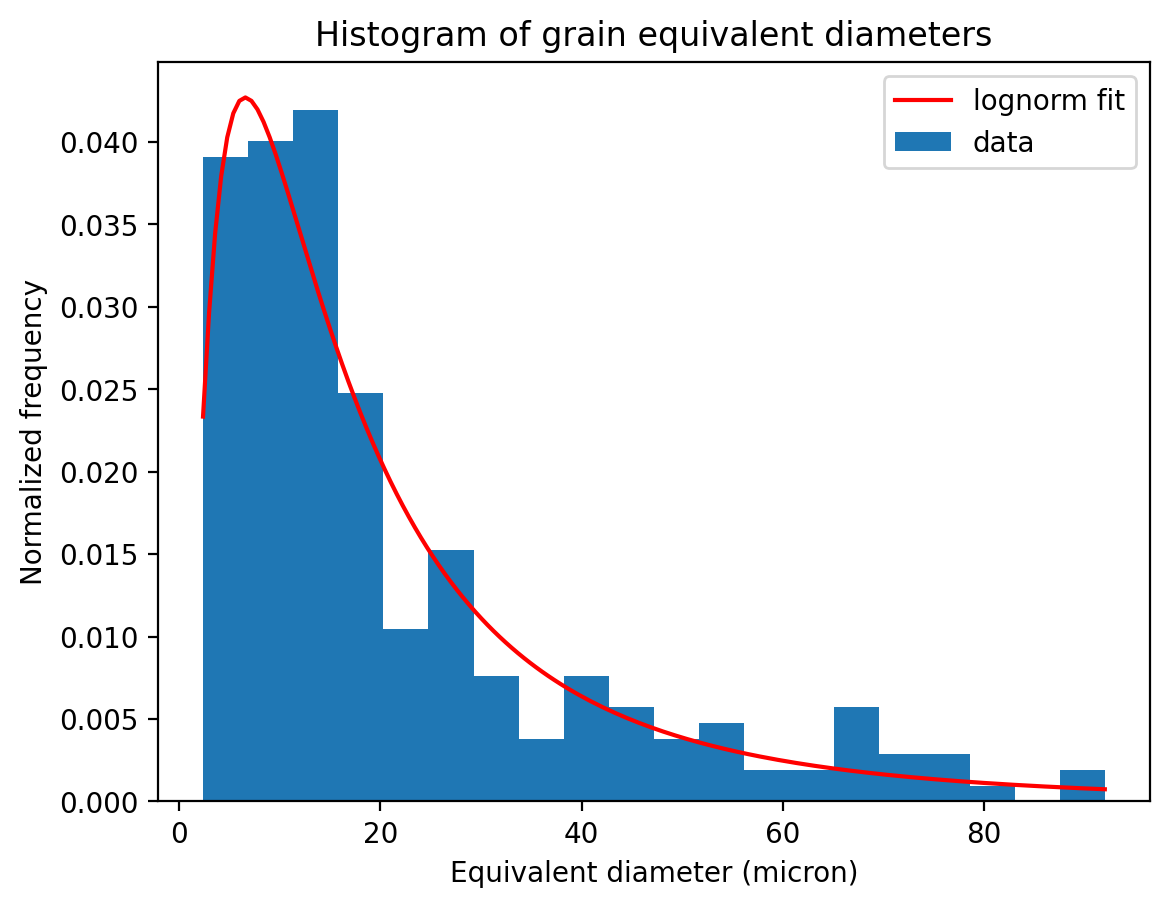

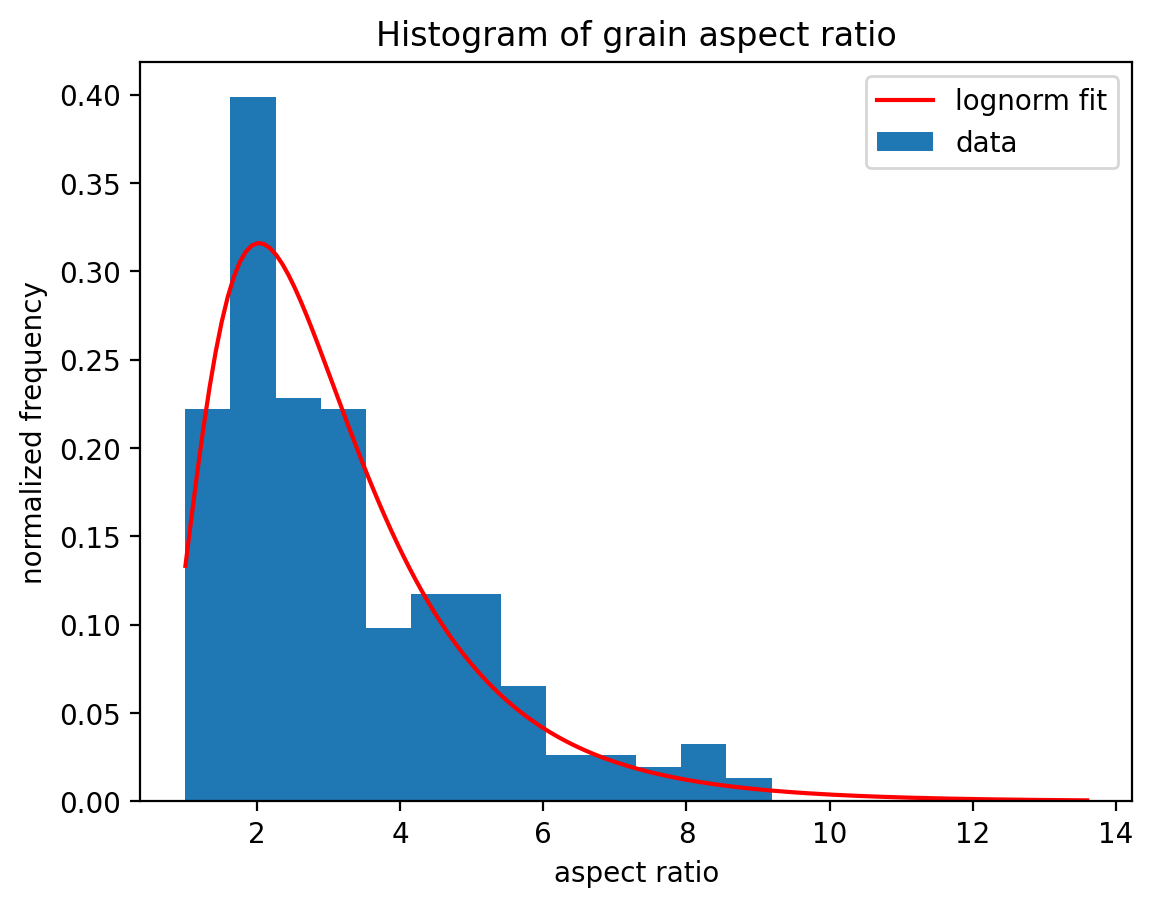

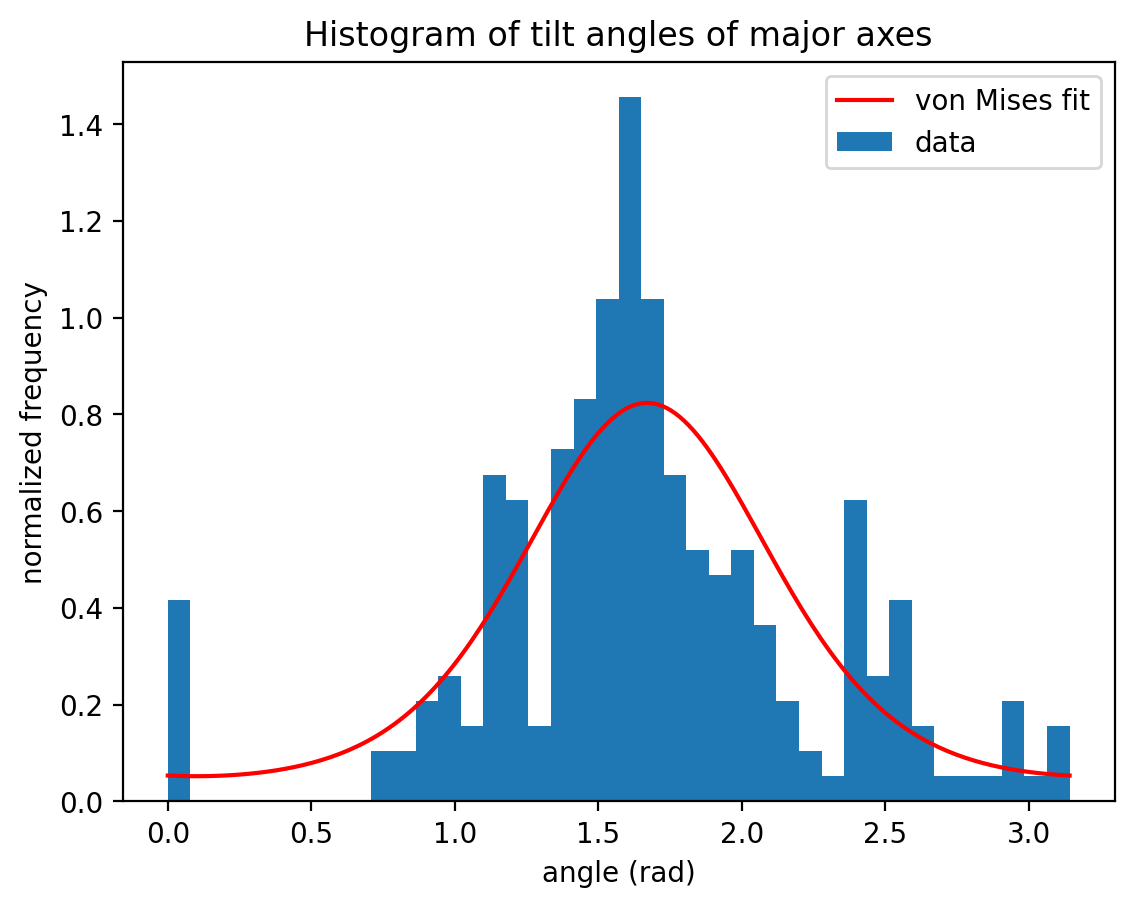

Analyzed microstructure of phase #0 (Iron fcc) with 245 grains.
Median values: equiv. diameter: 15.492 micron, aspect ratio: 2.71, tilt angle: 11.298°
Std. dev: equivalent diameter: 0.928 micron, aspect ratio: 0.538, tilt angle: 62.621°


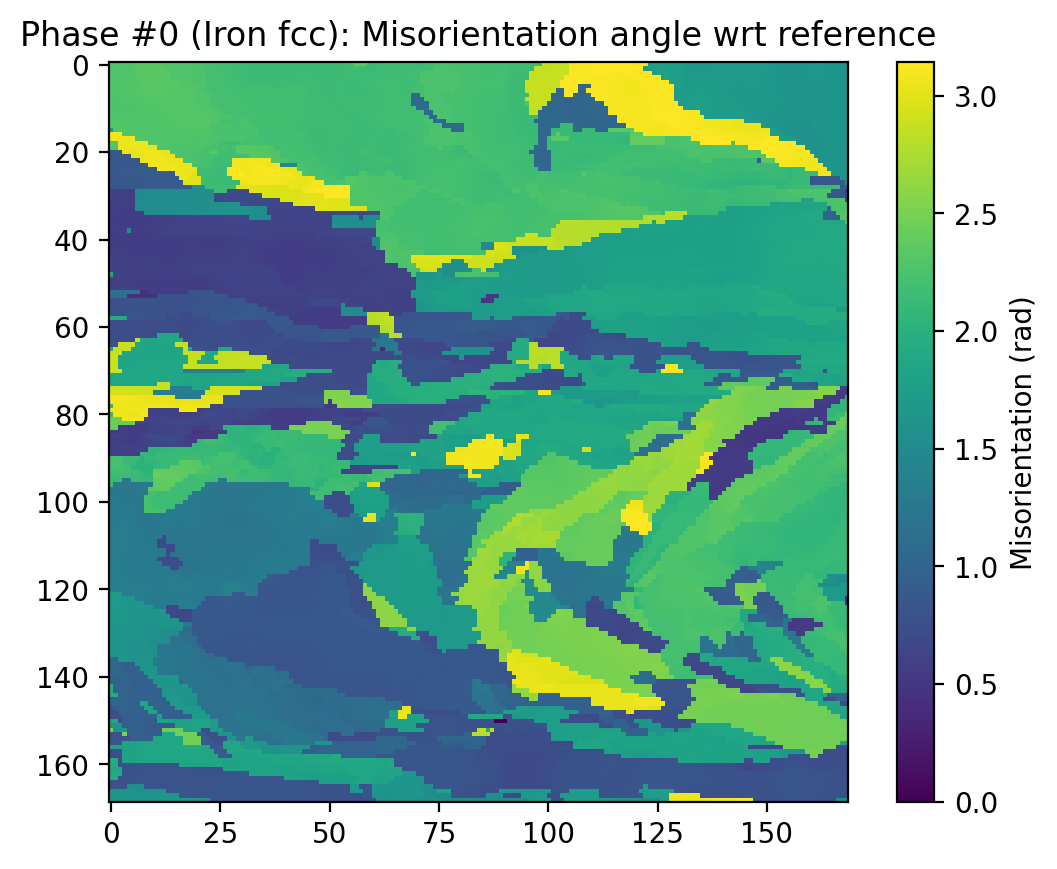

/mnt/c/Users/youse/kanapy/src/kanapy/texture.py:1371: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


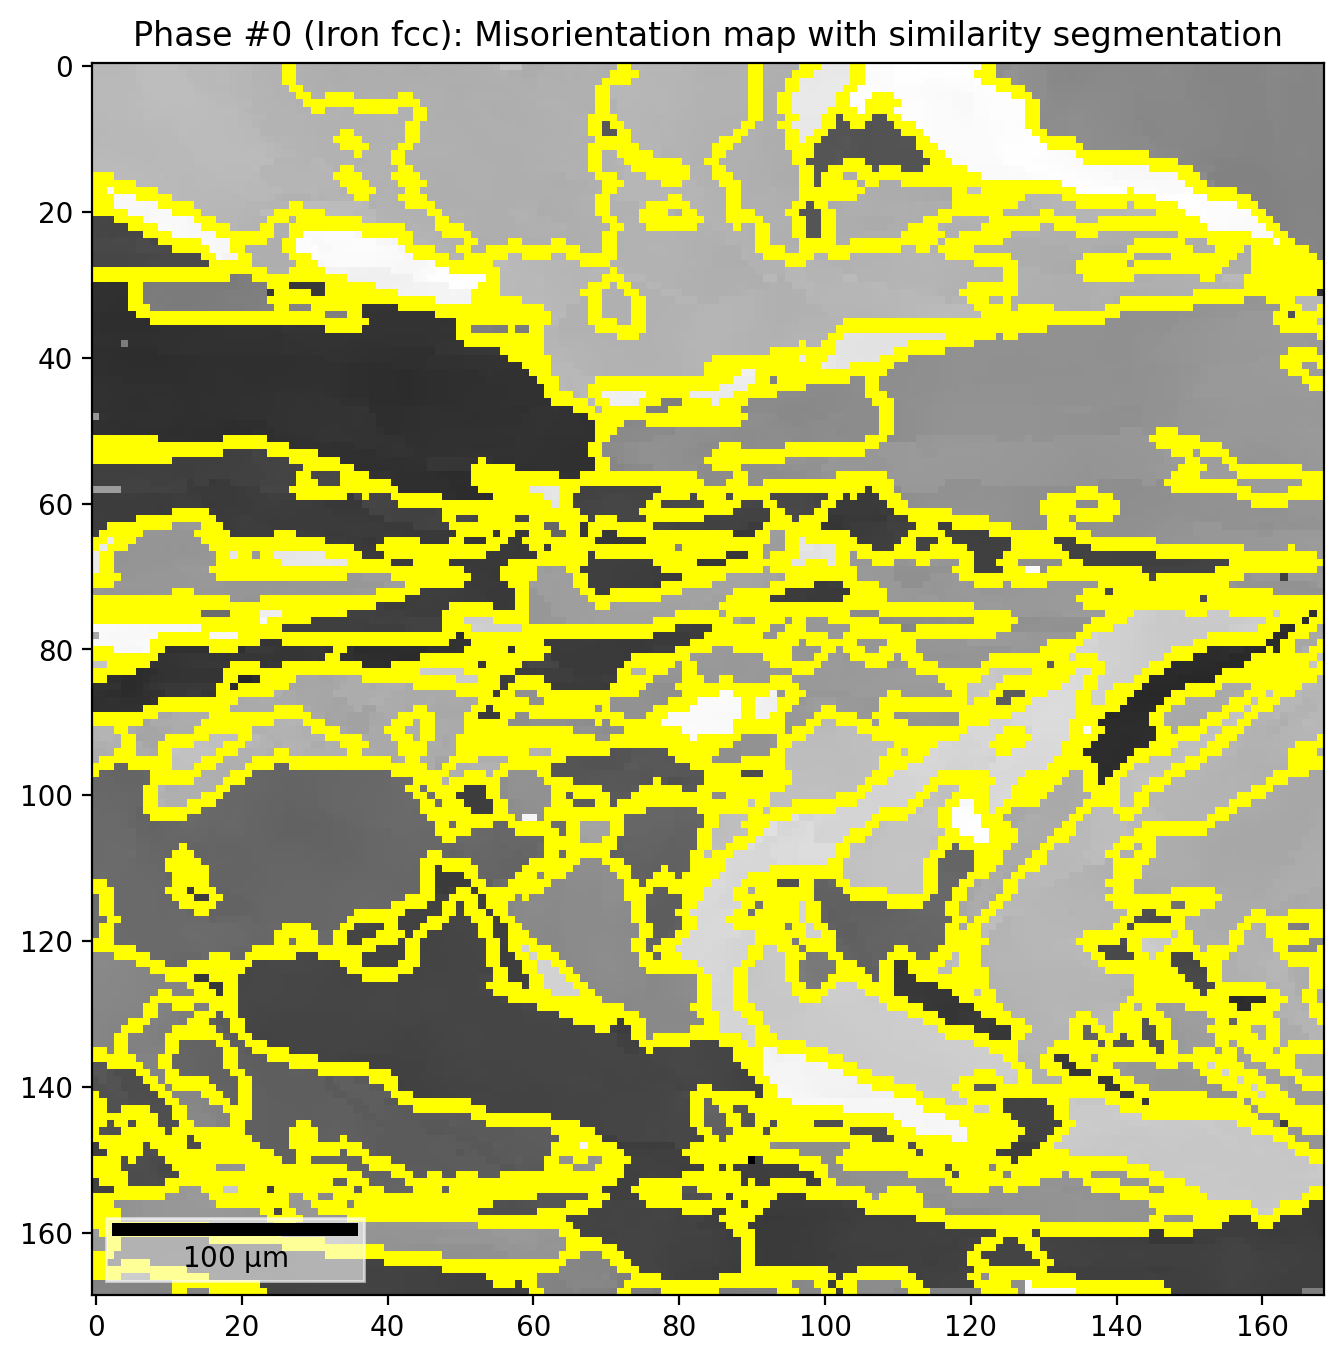

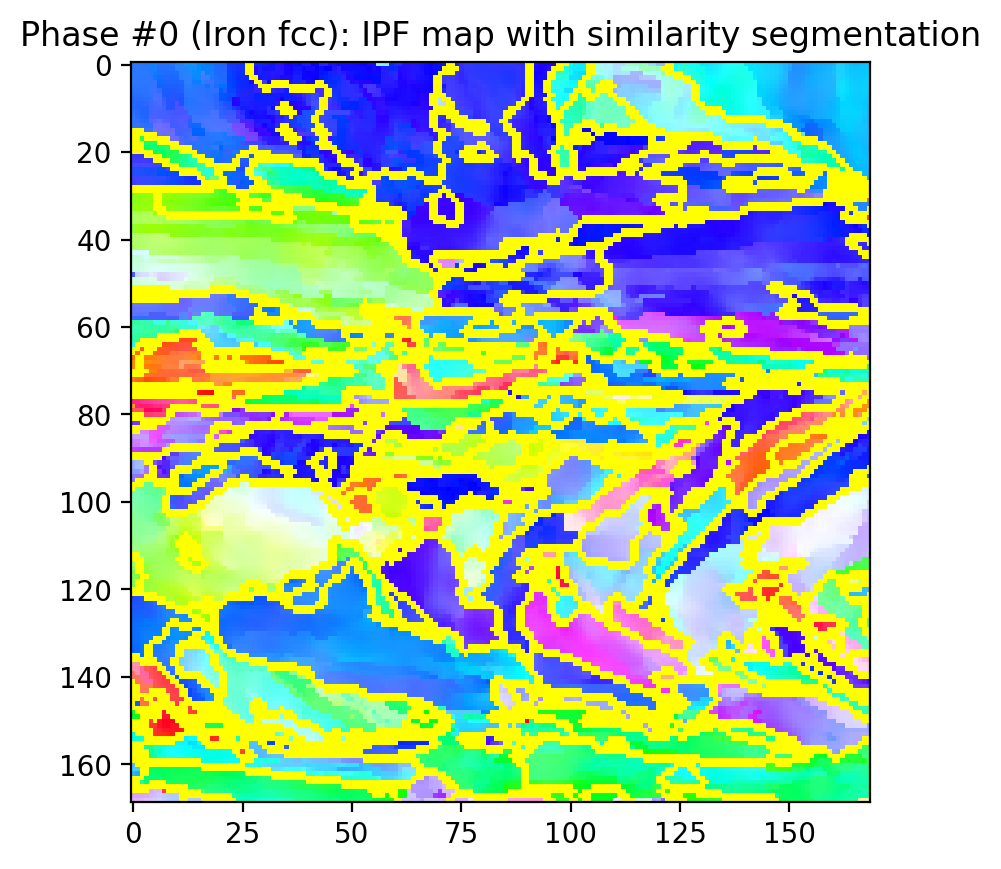

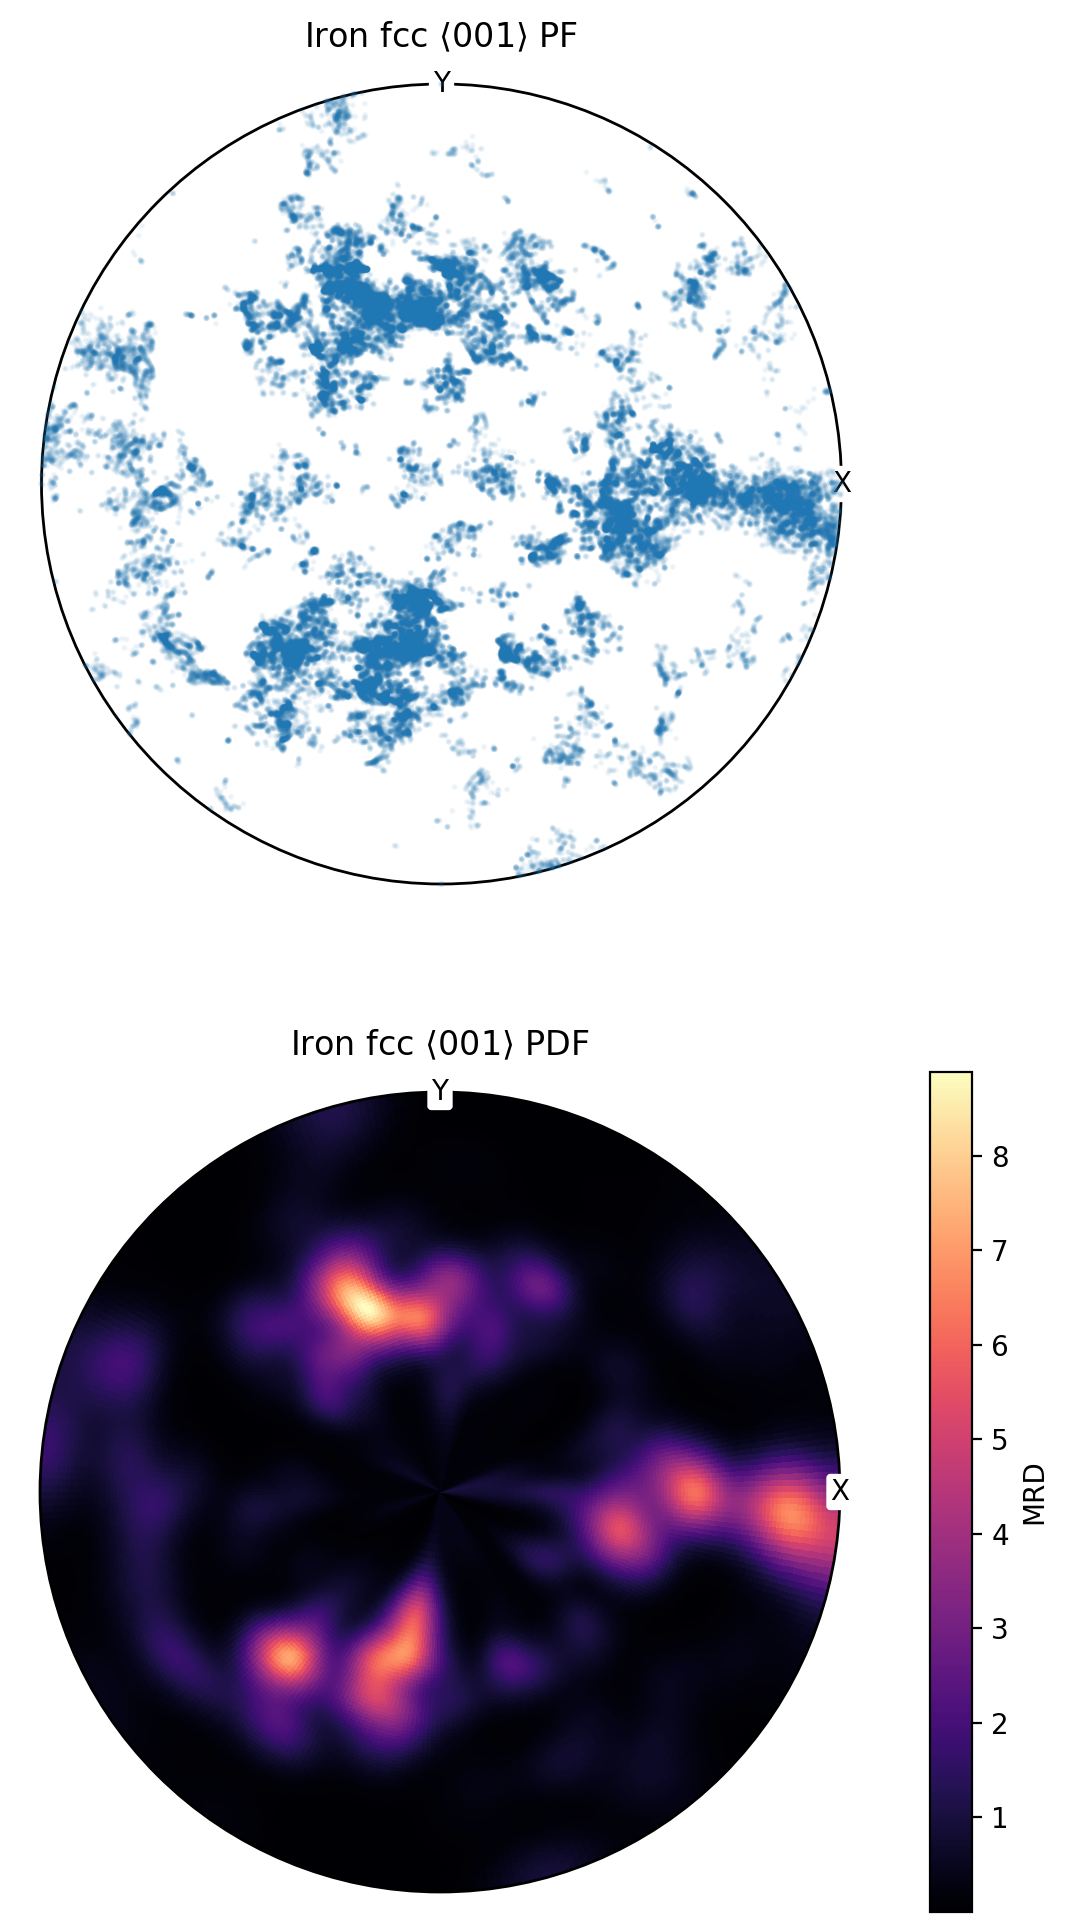

Step 2 completed: EBSD map loaded from ebsd_316L_500x500.ang
######################################################################################




########################################################################################
Step 3: Extracting microstructure statistics .........................................



Step 3 completed: Microstructure statistics extracted................................
#####################################################################################




########################################################################################
Step 4: Generating RVE ...............................................................



Creating an RVE based on user defined statistics
    Analyzed statistical data for phase iron_fcc (0)
    Total number of particles  = 6
  RVE characteristics:
    RVE side lengths (X, Y, Z) = (15, 15, 15) (um)
    Number of voxels (X, Y, Z) = (15, 15, 15)
    Voxel resolution (X, Y, Z) = [1. 1. 1.](um)
    Total

100%|██████████████████████████████████████████████████████████████████████████████| 1441/1441 [00:05<00:00, 247.04it/s]


Actual final volume of ellipsoids: 1832.2211003306522
Completed particle packing
25 overlapping particles detected after packing
Kinetic energy of particles after packing: 9872.727636712654






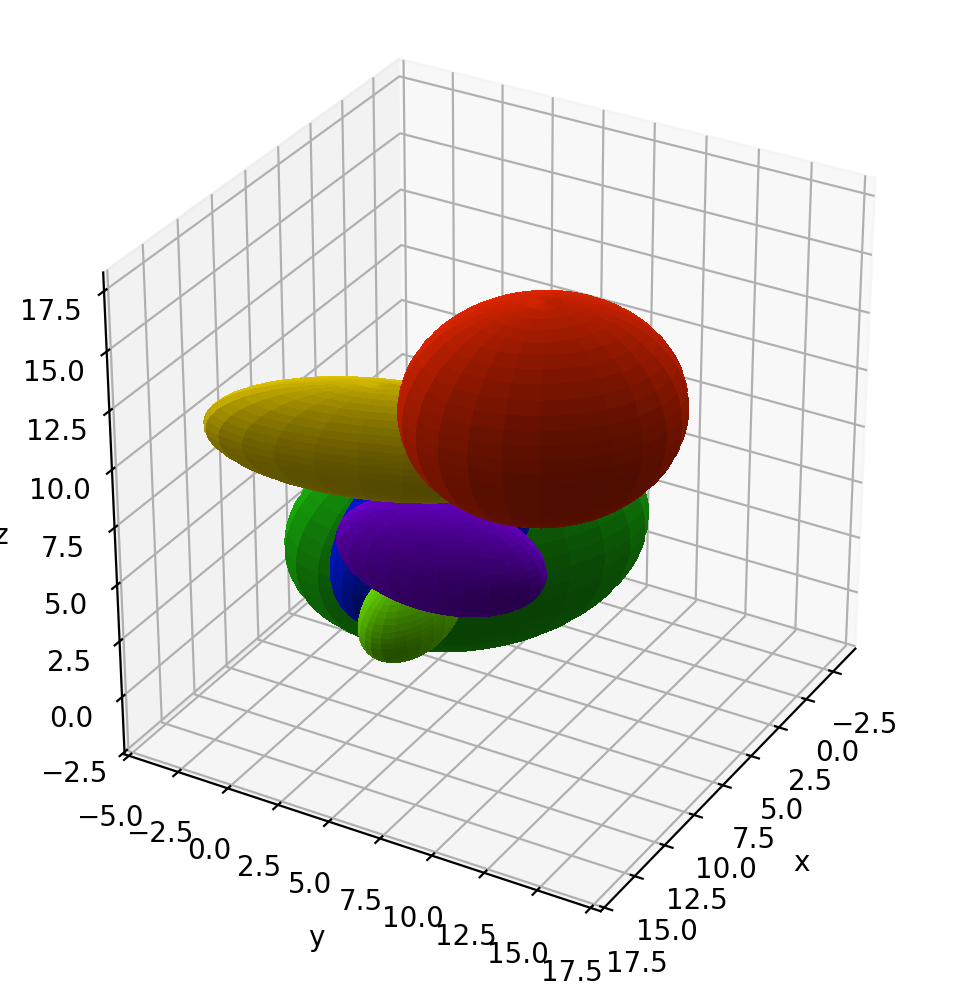

    Generating voxels inside RVE

Starting RVE voxelization
    Assigning voxels to grains


100%|██████████████████████████████████████████████████████████████████████████| 3375/3375 [00:00<00:00, 2431846.07it/s]


Completed RVE voxelization






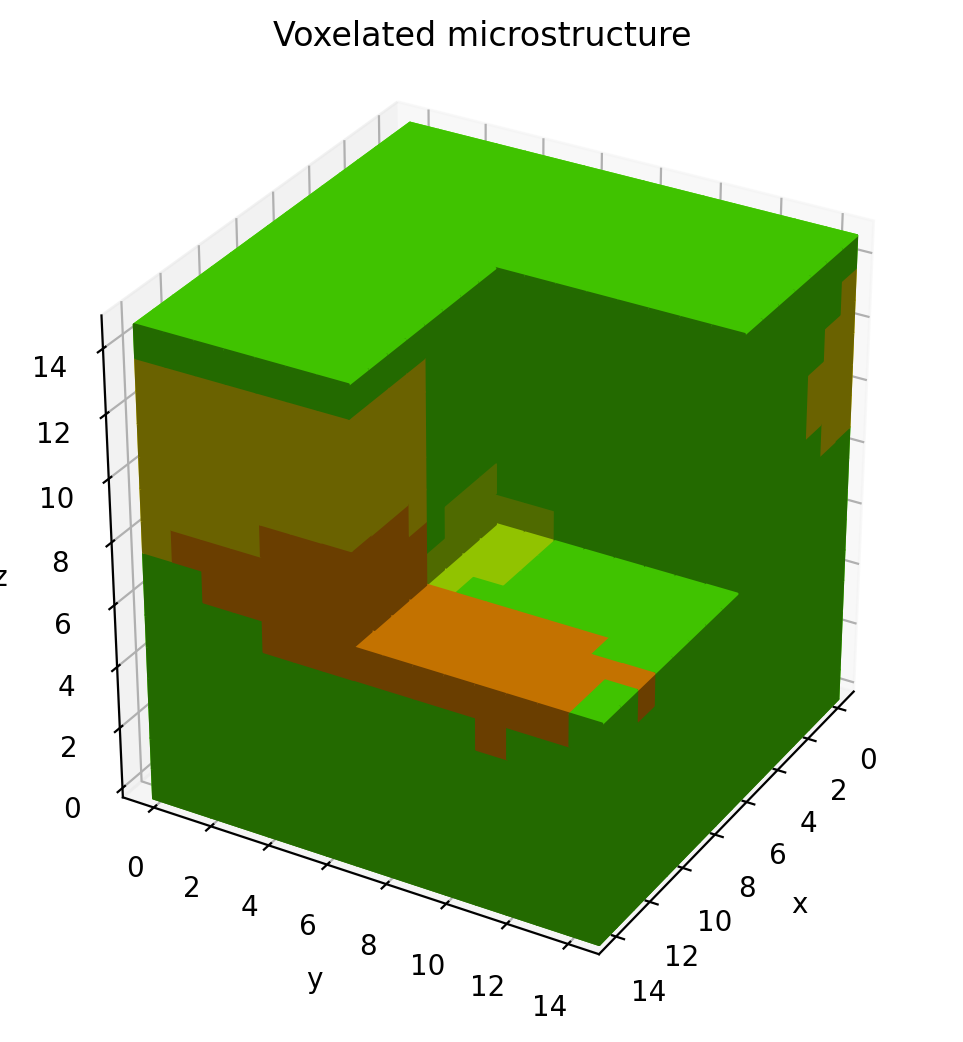

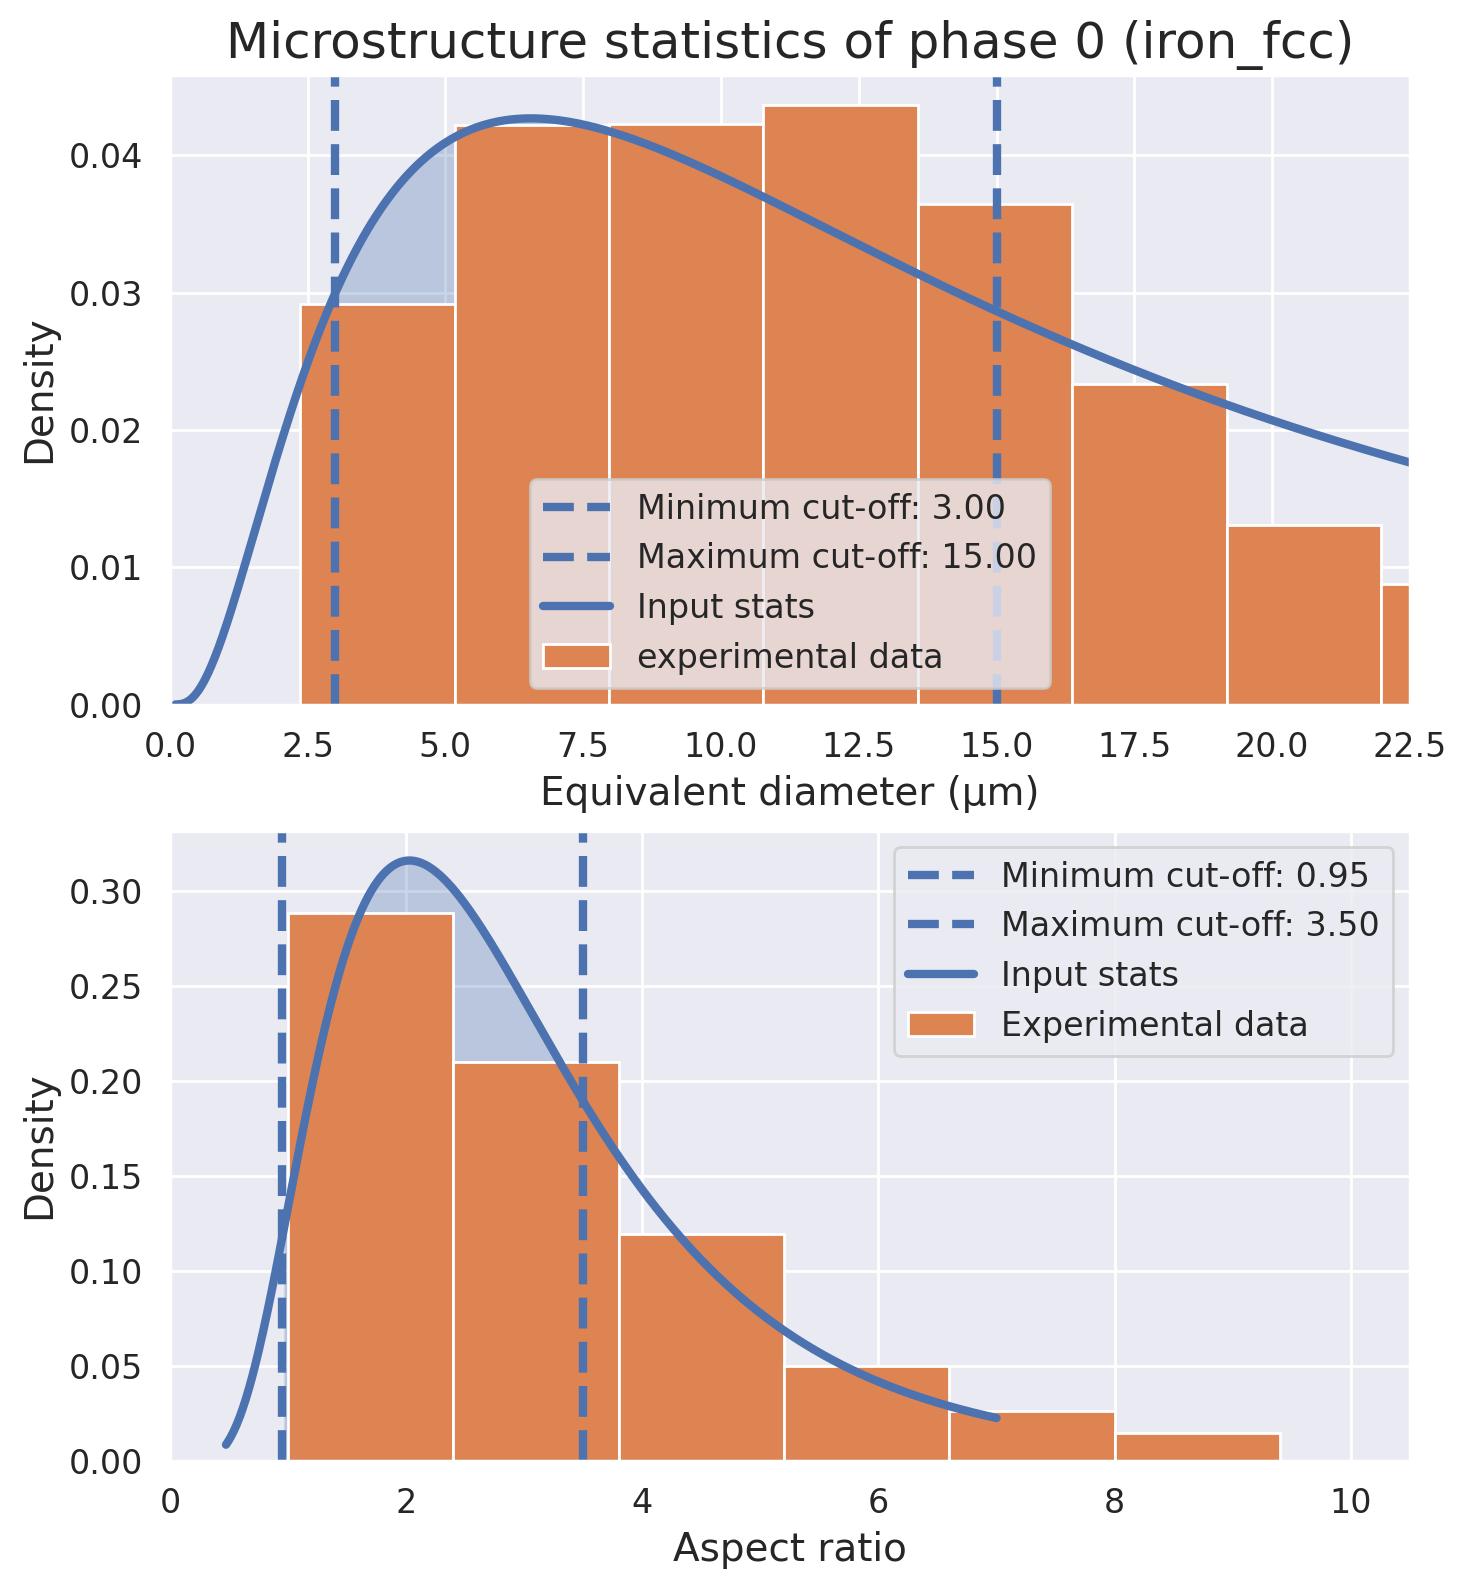

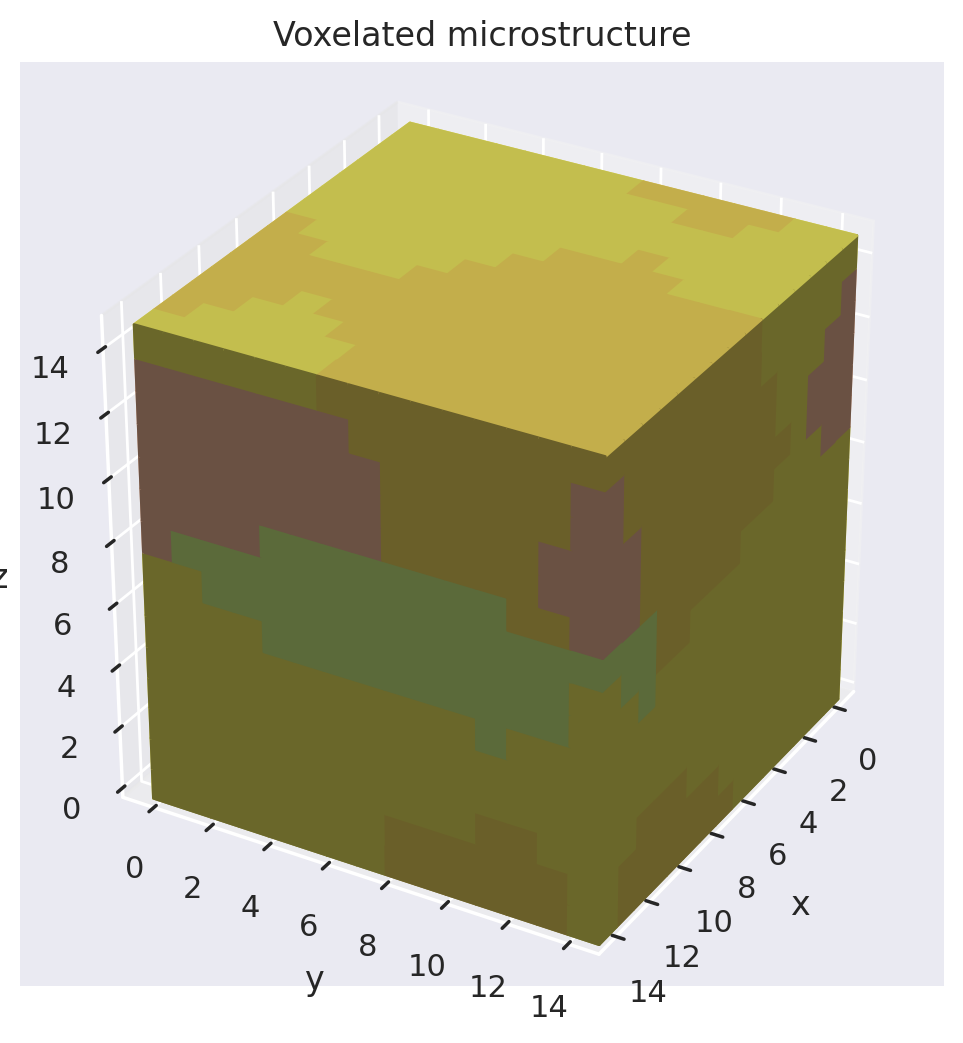

Step 4 completed: RVE generated.......................................................
######################################################################################




########################################################################################
Step 5: Exporting data ...............................................................



Saved to: /home/yousef/damaskWorkflows/ebsd2kanapy2damask/Version7/data/data_schema_damask.json
Step 5 completed: data saved in JSON file.............................................
######################################################################################




########################################################################################
Step 6: Building grid/material/load from JSON ........................................



cells:  15 × 15 × 15
size:   15.0 × 15.0 × 15.0 m³
origin: 0.0   0.0   0.0 m
# materials: 6



homogenization:
  direct:
    N_constituents: 1
    mechanical: {type: pass}
phase: {'0': null}

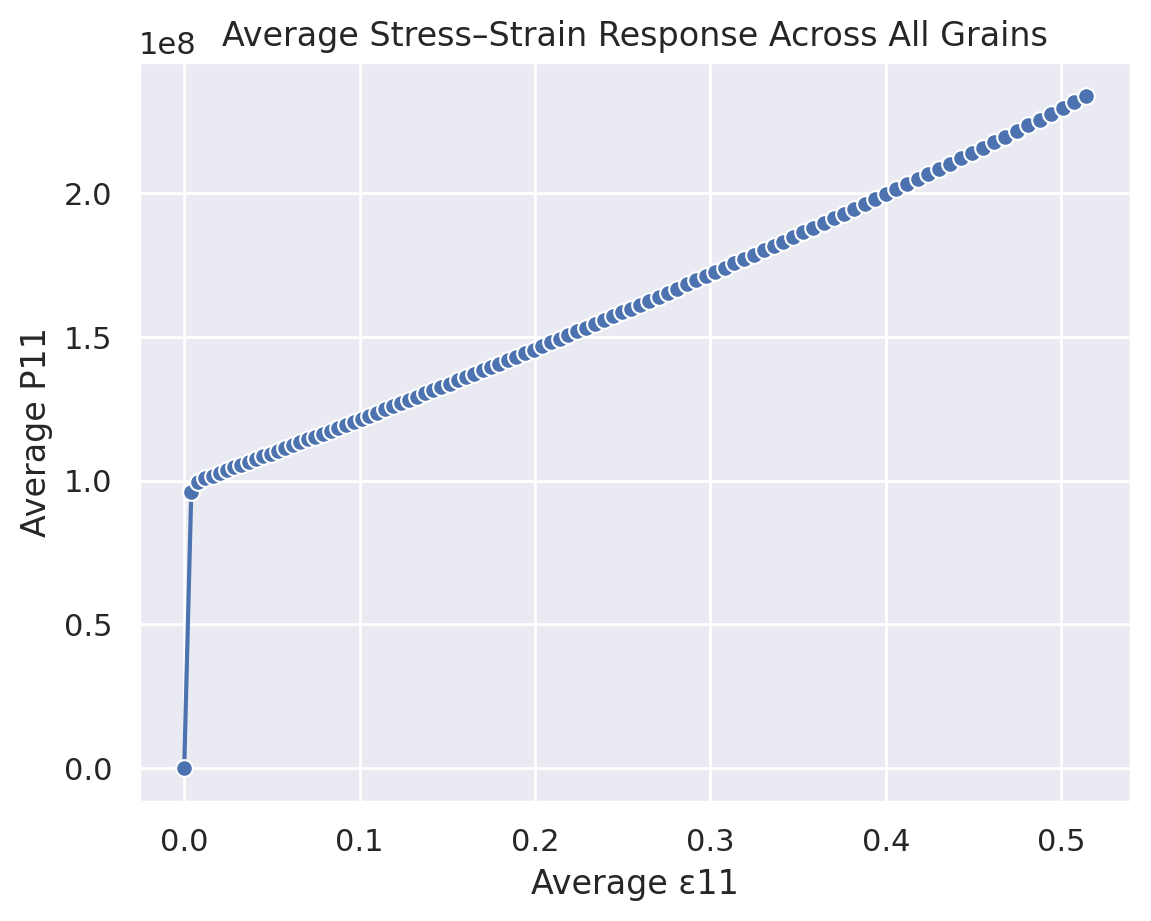

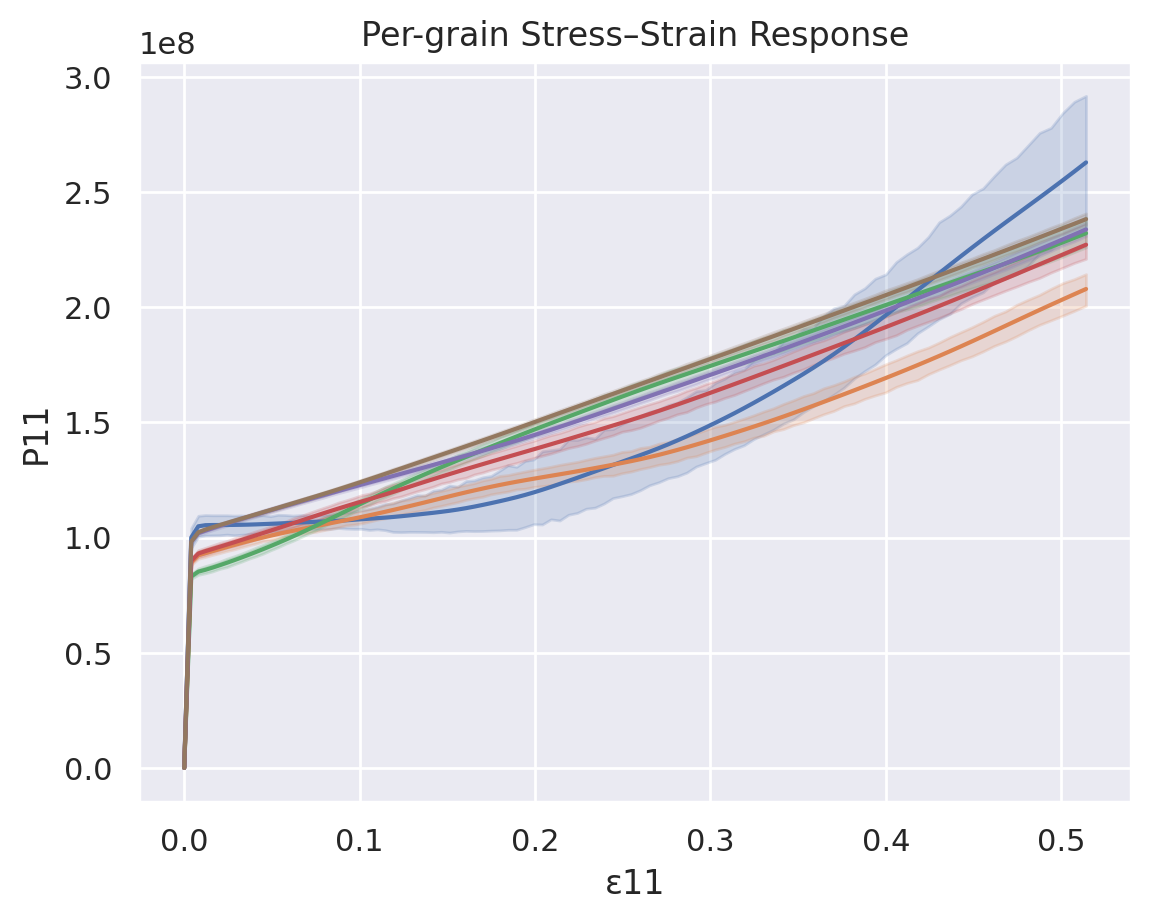

##################################################################################################
Step 8 completed: End of postprocessing ........................................................



########################################################################################
Step 9: updating json data file ......................................................



selected: ['increment_100']
Step 9 completed: End of updating ..............................................................
##################################################################################################



#####################################################################################################
Step 11: start remapping to data file .............................................................



old size of voxel in each direction: [1. 1. 1.]
old size of RVE in each direction: [15. 15. 15.]
old number of voxels in each direction: [15 15 15]
New size of voxel in each direction: [0.6,

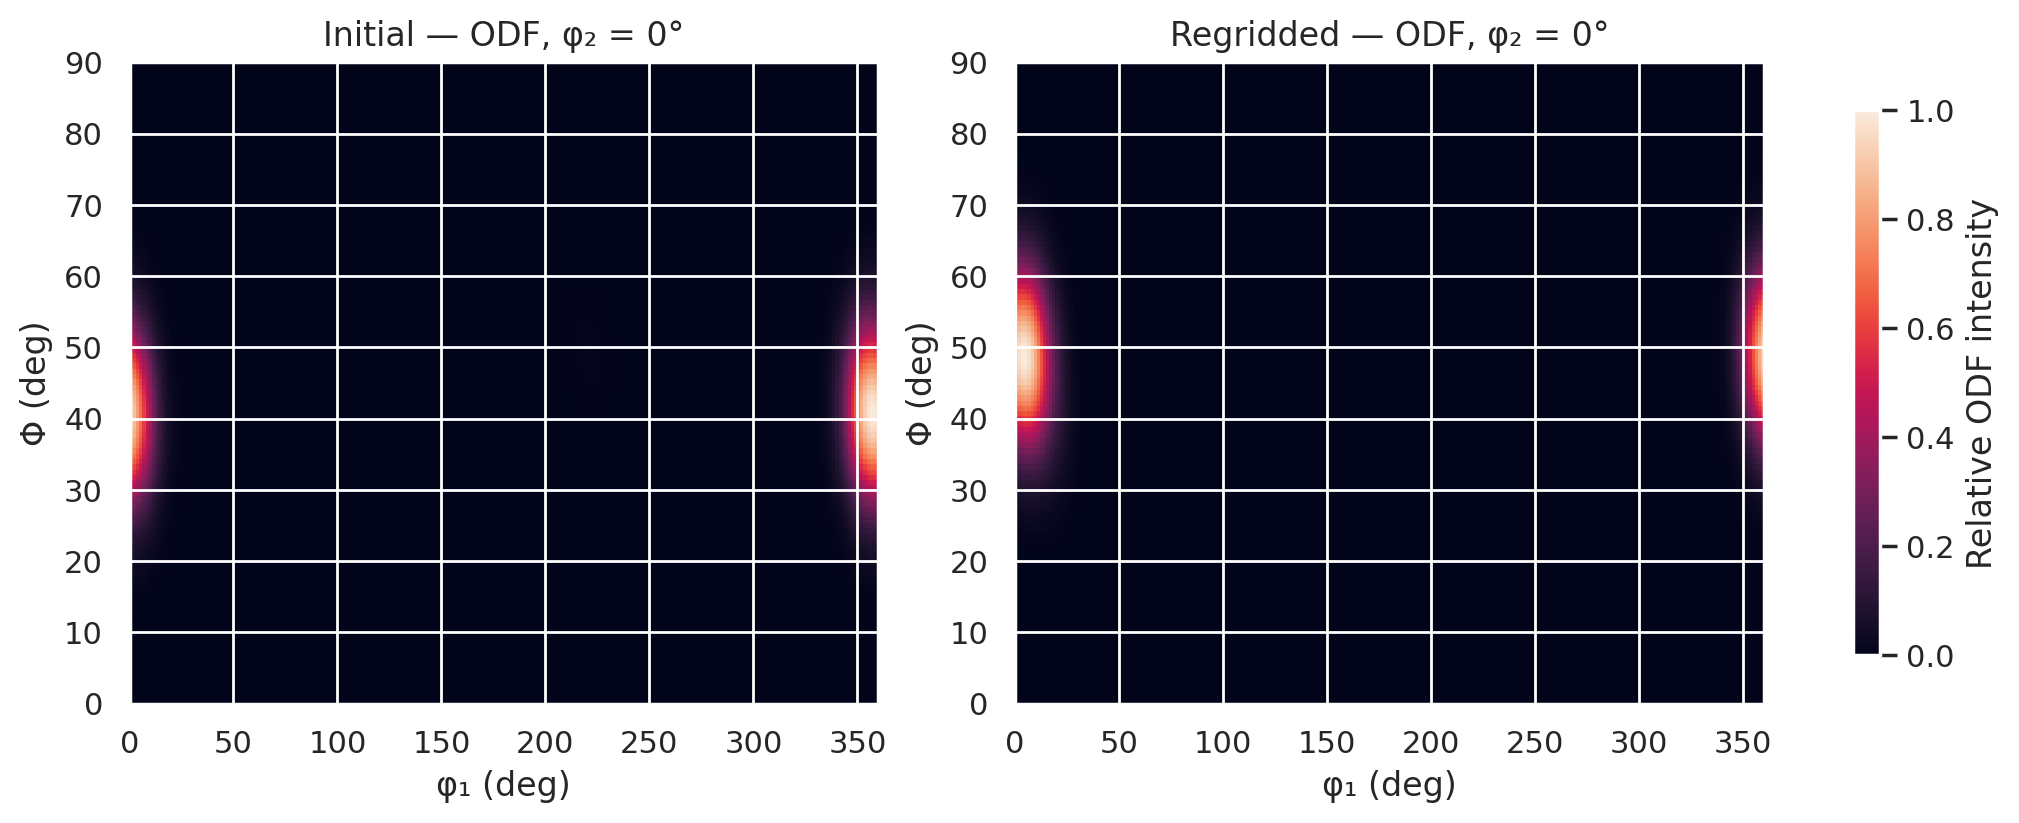

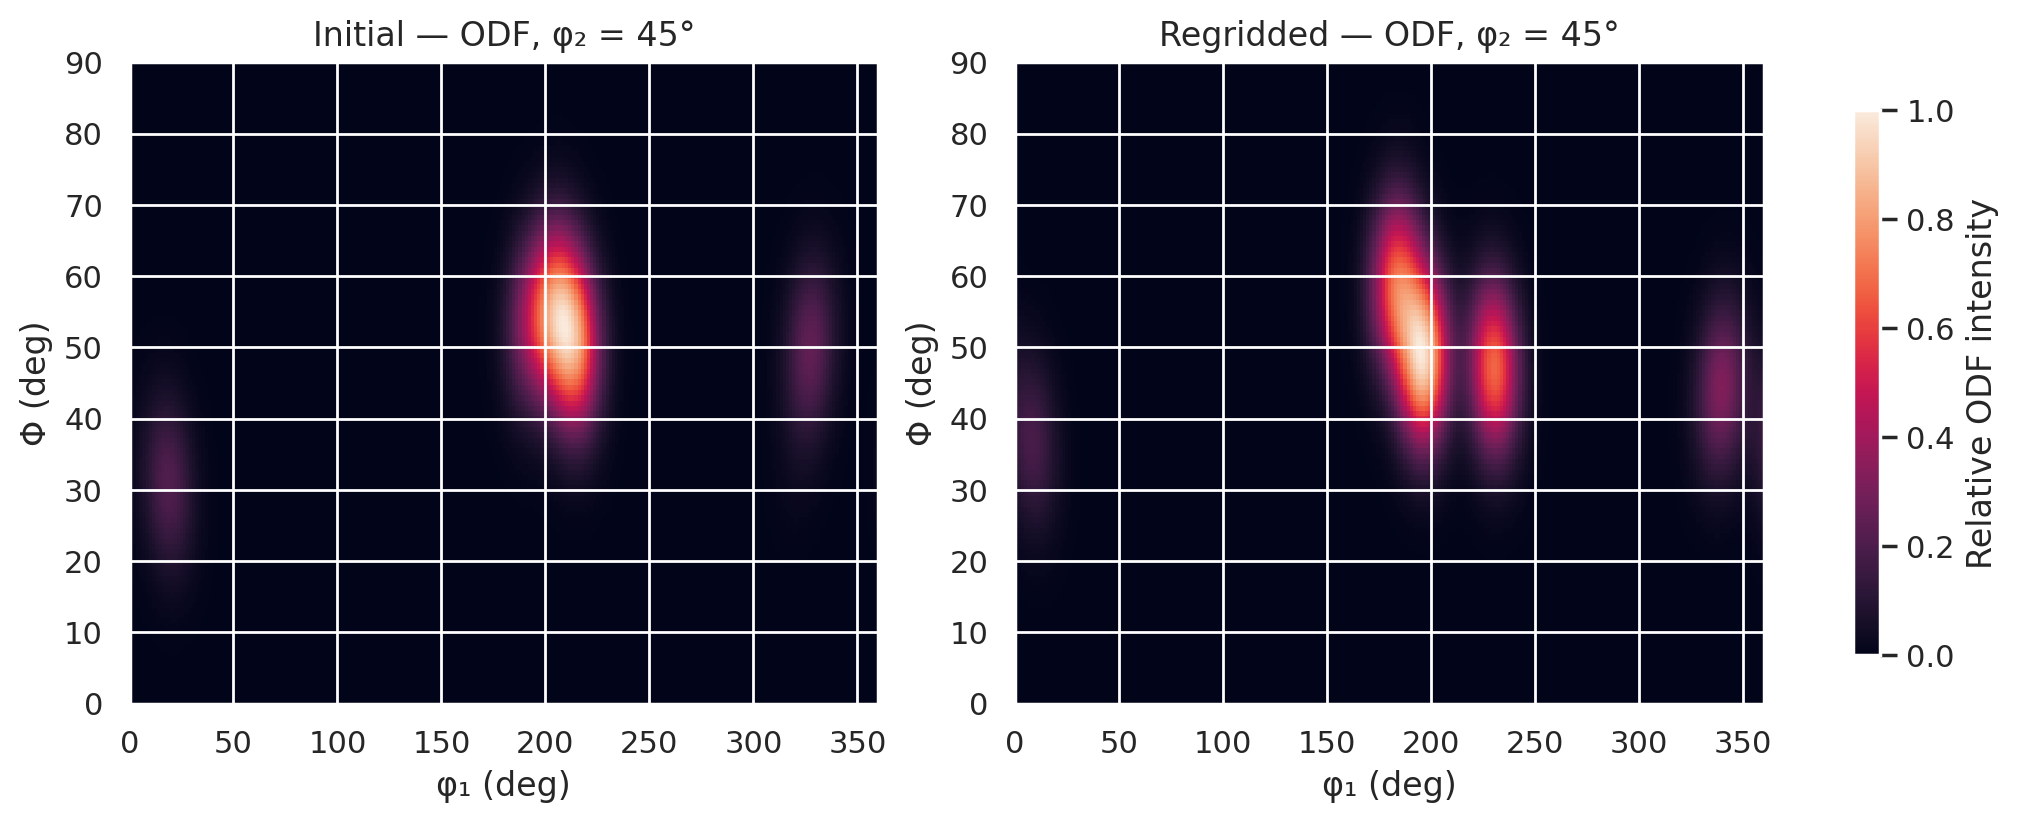

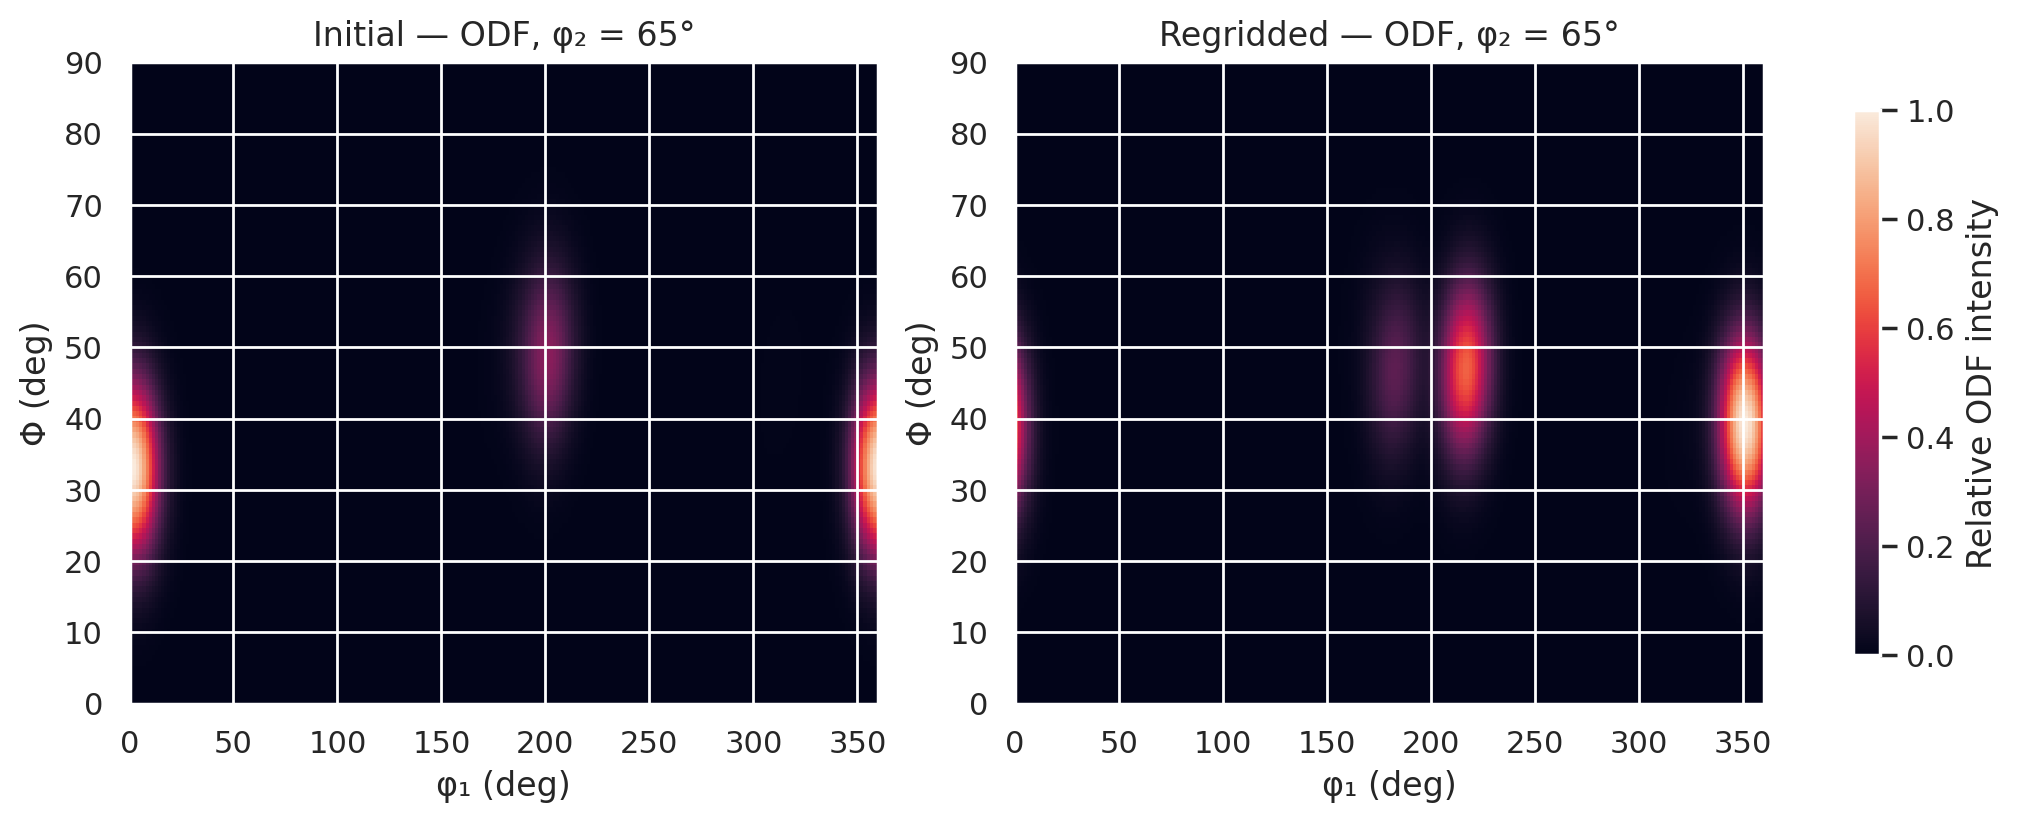

Step 14 completed: End of comparing ............................................................
##################################################################################################



#####################################################################################################
Step 12: Extract statistics from regridded RVE ....................................................



The initial microstructure





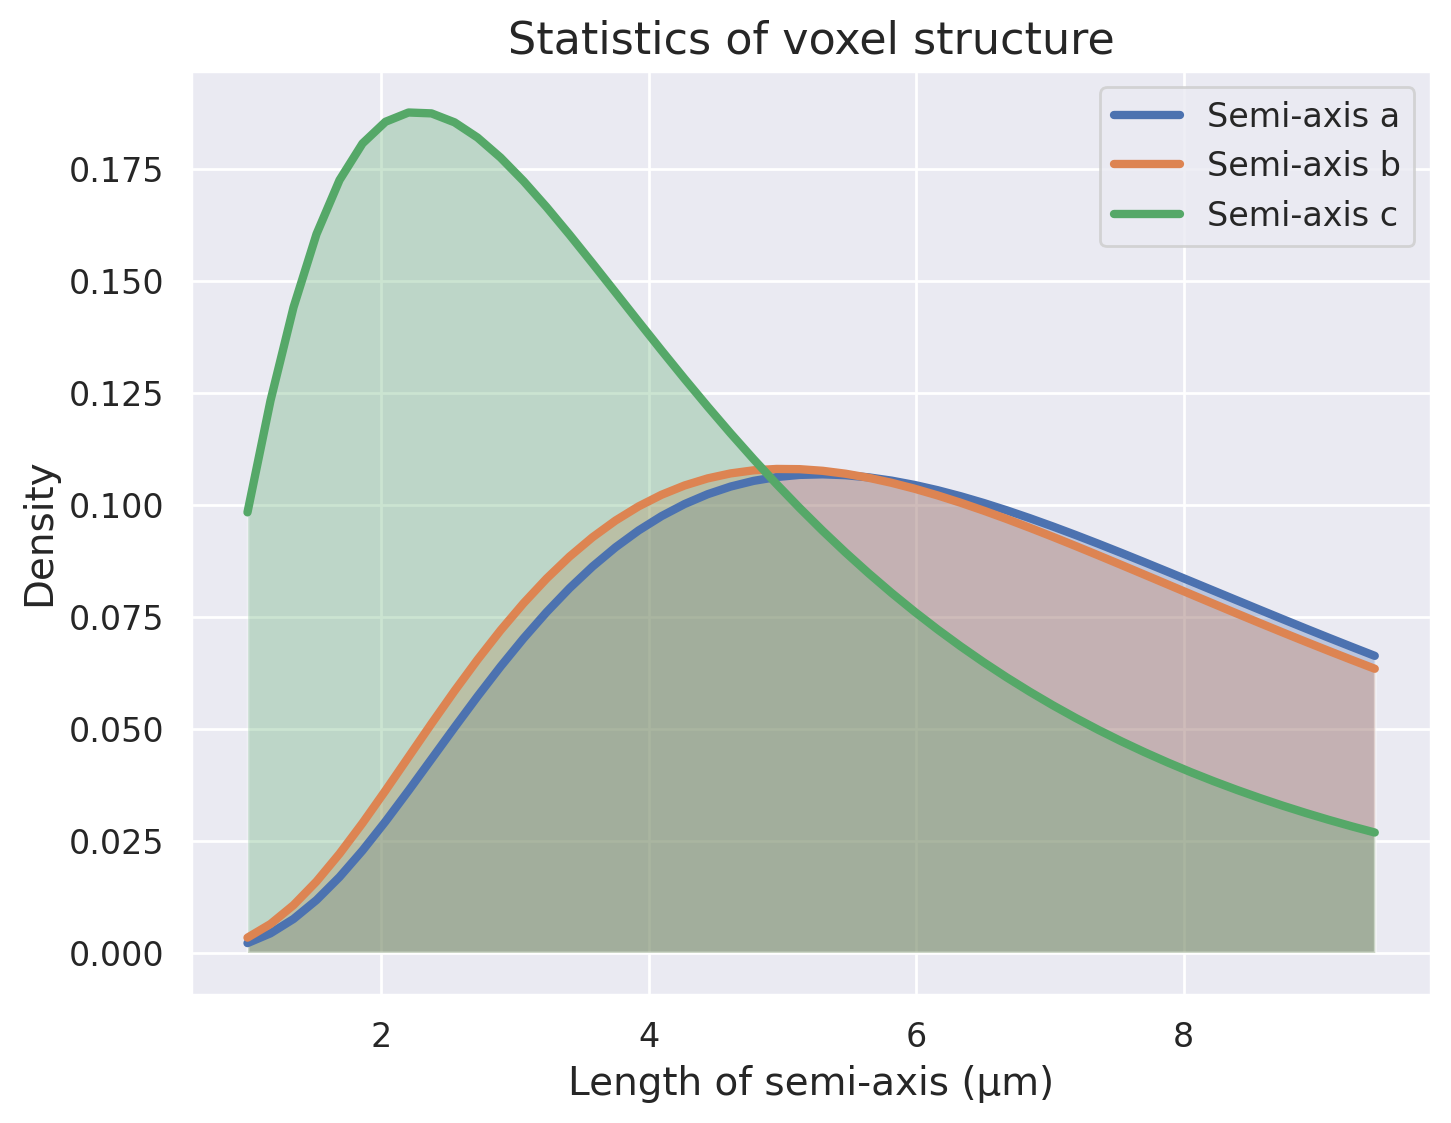




The regridded microstructure


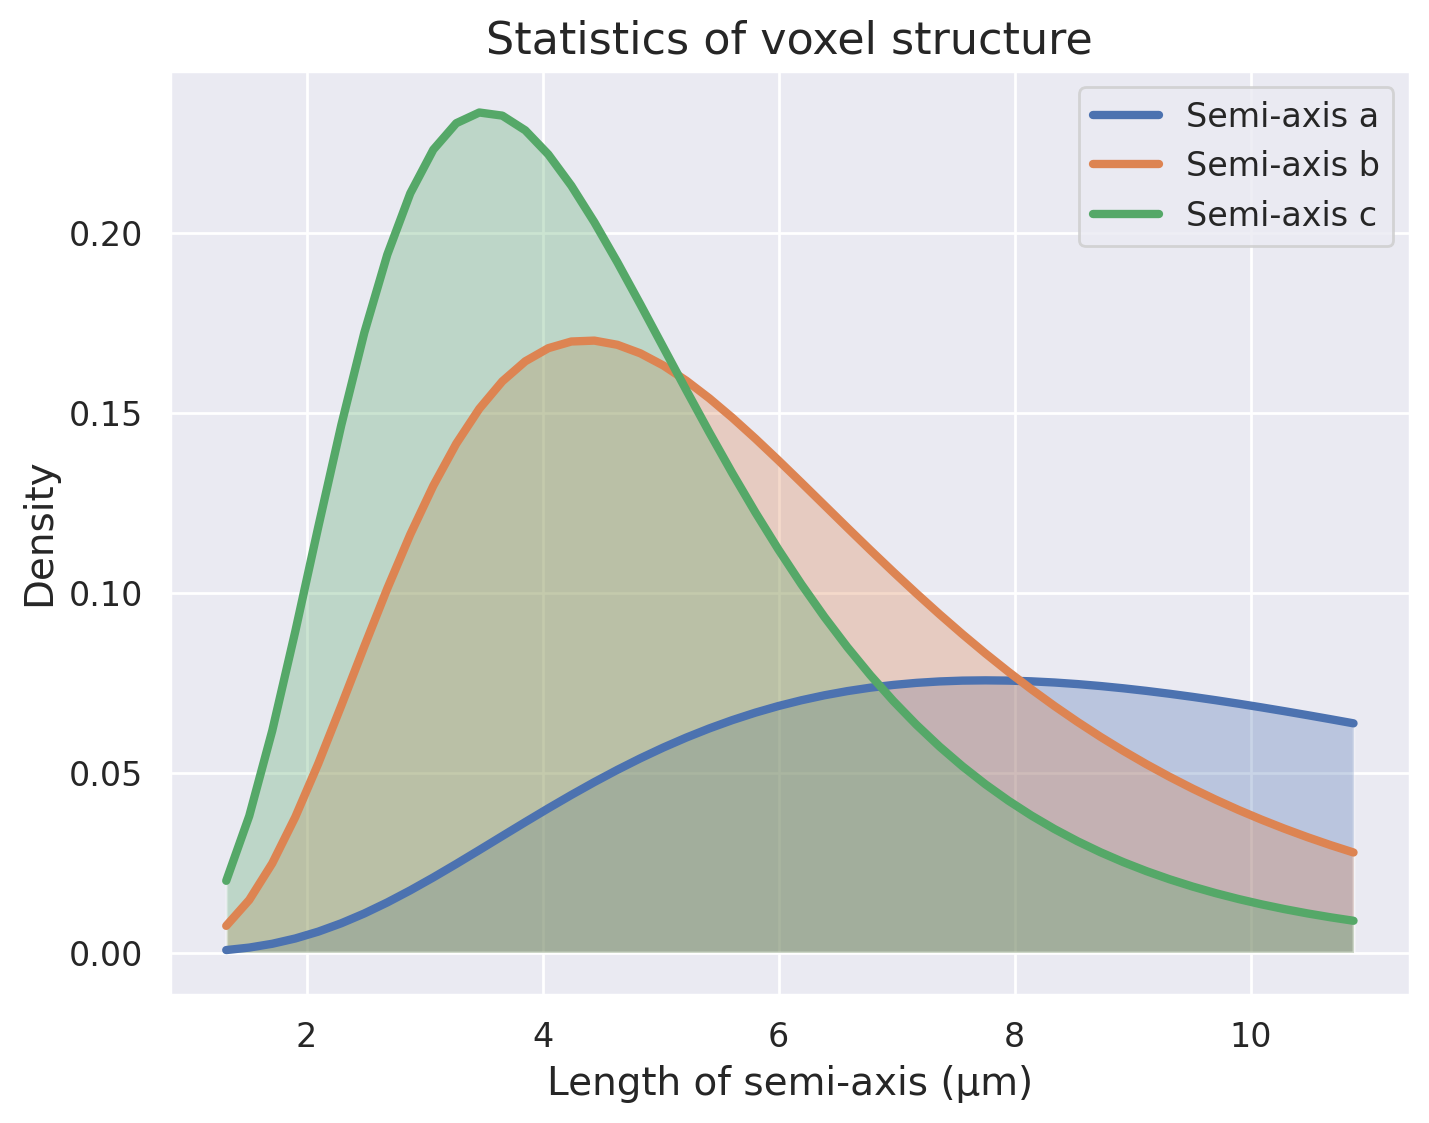




Step 12 completed: End of Extracting ...........................................................
##################################################################################################



#####################################################################################################
Step 13: Compare statistics .......................................................................





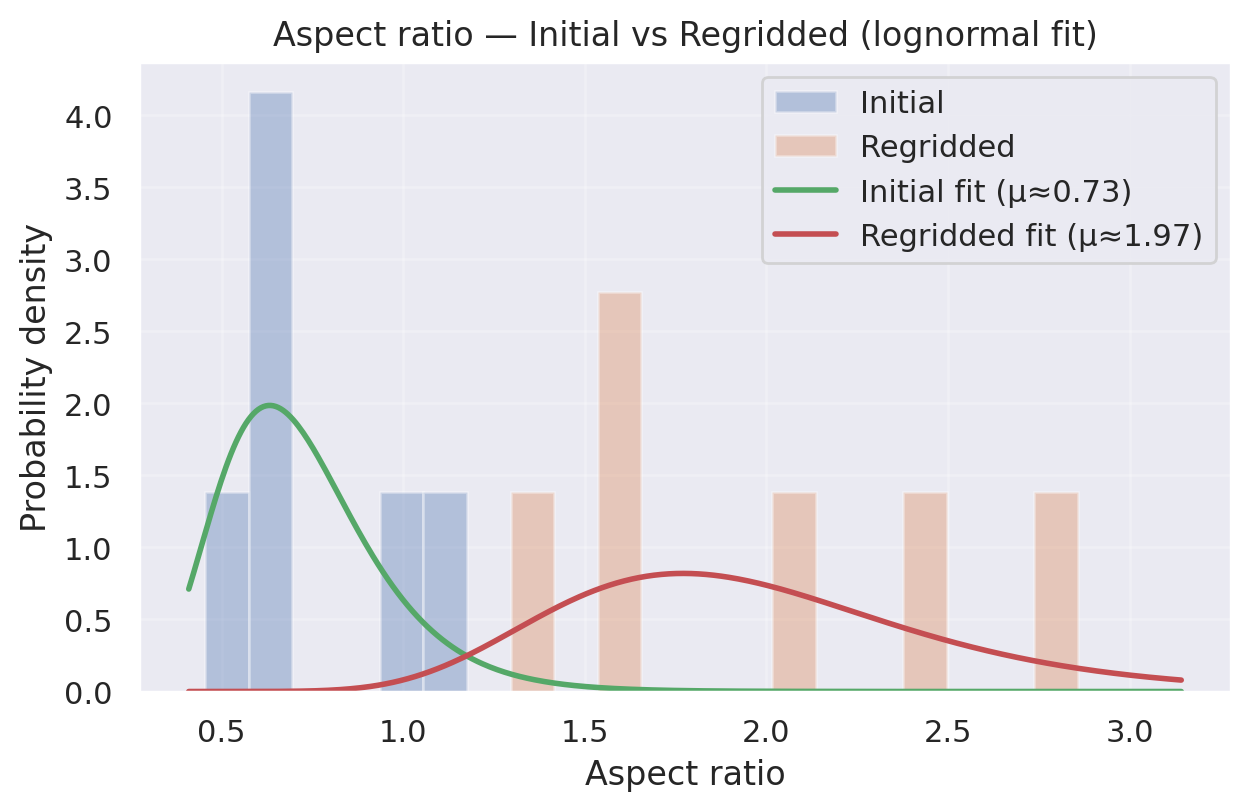

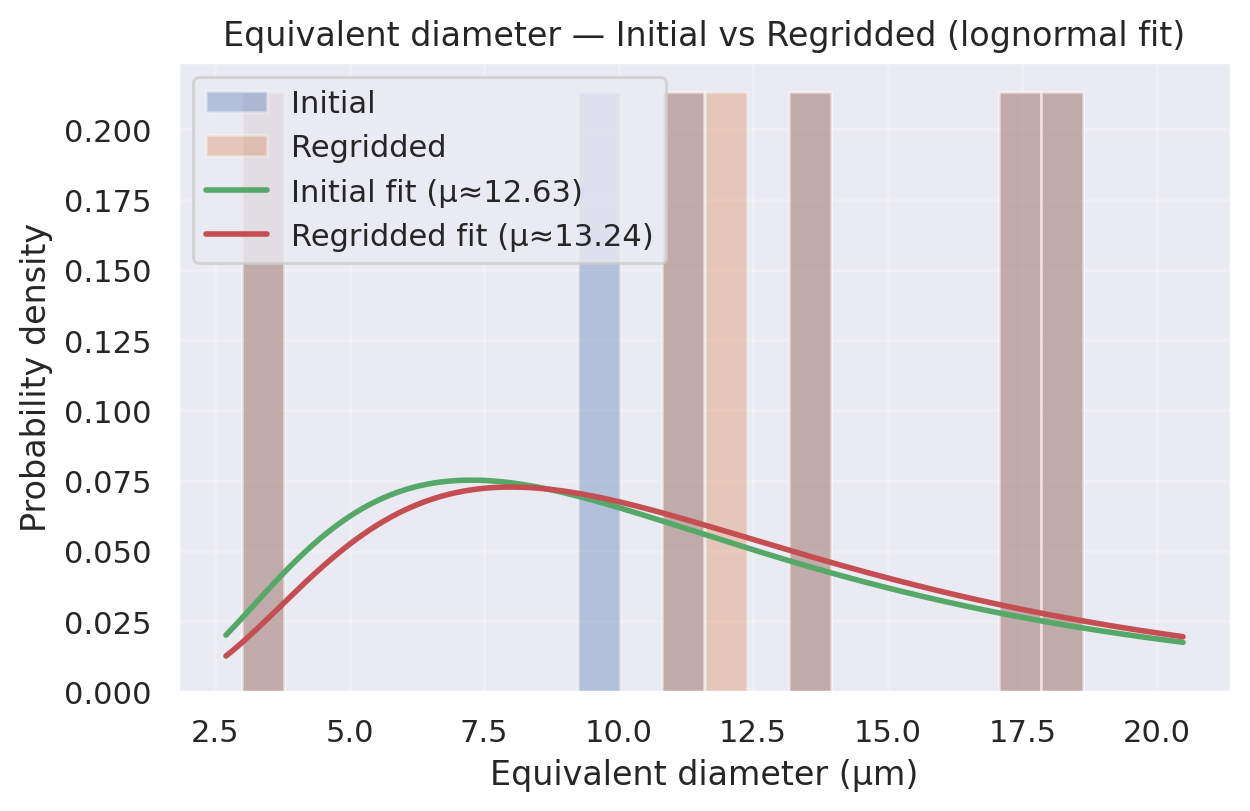

Step 13 completed: End of comparing ............................................................
##################################################################################################



Workflow completed successfully. Json file has been generated.


In [19]:
try:
    wf.run() # Run the workflow
    print("Workflow completed successfully. Json file has been generated.")
except Exception as e:
    print(f"An error occurred during the workflow execution: {str(e)}")

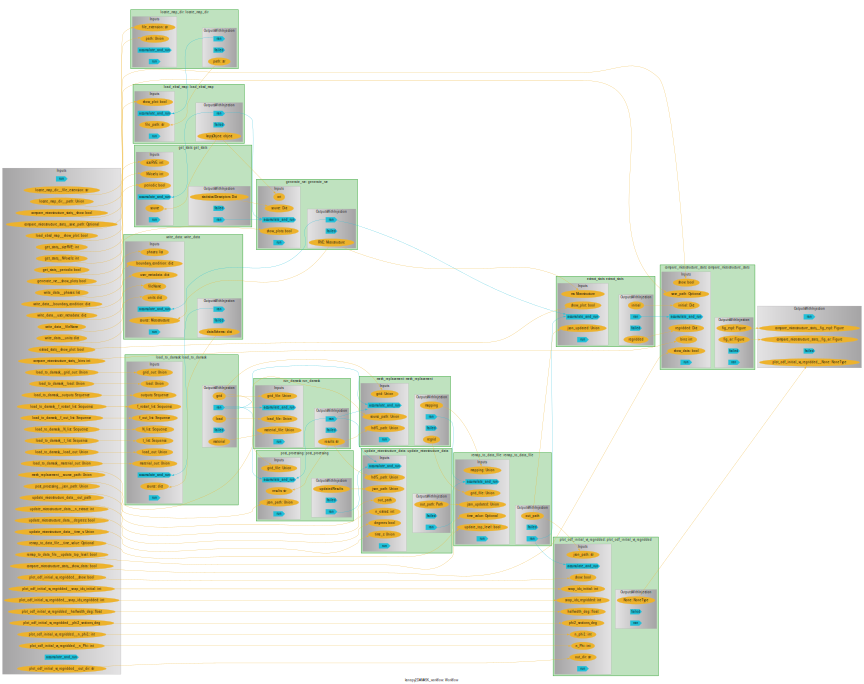

In [20]:
wf.draw(size=(12,10))
